# **Human Trafficking Case Study** 
<img src="https://static.wixstatic.com/media/854ff1_b8b778c28cae41198c03d9058617f0cc~mv2.png/v1/fill/w_529,h_937,al_c,q_90,enc_auto/854ff1_b8b778c28cae41198c03d9058617f0cc~mv2.png" width="300px">

- **UNODC**: (`United Nations Office on Drugs and Crime`)
- **CDE**: (`Crime Data Explorer`) 

In [1]:
import pandas as pd 
import numpy as np 
import warnings
import os 
import re 
import sqlite3 
from collections import defaultdict

import matplotlib.pyplot as plt 
import seaborn as sns 
import squarify as sq 

from matplotlib.colors import ListedColormap

from typing import List, Dict 
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 150 
pd.options.display.max_columns = 200 
plt.style.use("ggplot")

DATASET_PATH: str = os.path.join( "../datasets/HumanTrafficking/")

## **UNODC Datasets**
- `CodeBook`: https://dataunodc.un.org/sites/dataunodc.un.org/files/metadata_trafficking_in_persons.pdf
1. **Detected trafficking victims**: Number of persons identified by national authorities as having experienced the “recruitment,
transportation, transfer, harbouring or receipt of persons, by means of the threat or use of force or
other forms of coercion, of abduction, of fraud, of deception, of the abuse of power or of a position
of vulnerability or of the giving or receiving of payments or benefits to achieve the consent of a
person having control over another person, for the purpose of exploitation. Exploitation shall
include, at minimum, the exploitation of the prostitution of others or other forms of sexual exploitation, forced labour or services, slavery or practices similar to slavery, servitude or the
removal of organs.” An individual may experience various types of exploitation in one trafficking event. For example, in
the case of forced marriage, it is common for women to endure sexual and domestic exploitation, or
forced labour.
2. **Offences of trafficking in persons**: Number of offences of trafficking in persons reported in a given year in a given country.
3. **Persons brought into formal contact**: Number of persons brought into contact, suspected, arrested, investigated or cautioned for
trafficking in persons and related offenses in a given year.
4. **Persons prosecuted**: Number of persons prosecuted for trafficking in persons and related offenses in a given year.
5. **Persons convicted**: Persons found guilty by any legal body authorized to pronounce a conviction
under national criminal law, whether or not the conviction was later upheld. Persons receiving a
sentence after plea-bargaining, or in an abbreviated court procedure, should be counted as persons
convicted.

In [170]:
htf: 'DataFrame' = pd.read_excel( os.path.join(DATASET_PATH, 'data_glotip.xlsx') )
columns: List[str]  = htf.iloc[1].tolist()
htf = htf.iloc[2:]
htf.columns = columns
htf['Value' ] = htf['txtVALUE'].replace({"<5": "4"}).apply(lambda row: row.replace(",", "") ).astype(int)
country_origins: List[str] = htf.query("Indicator == 'Detected trafficking victims' ").groupby('Country')['Value'].sum().sort_values(ascending=False).head(10).index.tolist() 

htf.head() 

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,txtVALUE,Source,Value
2,ABW,Aruba,Americas,Latin America and the Caribbean,Detected trafficking victims,by country of repatriation,Ukraine,Total,Total,2010,Counts,<5,GLOTIP,4
3,AFG,Afghanistan,Asia,Southern Asia,Detected trafficking victims,by country of repatriation,Abroad,Total,Total,2003,Counts,<5,GLOTIP,4
4,AFG,Afghanistan,Asia,Southern Asia,Detected trafficking victims,by country of repatriation,Abroad,Total,Total,2008,Counts,<5,GLOTIP,4
5,AFG,Afghanistan,Asia,Southern Asia,Offences of trafficking in persons,Total,Total,Total,Total,2013,Counts,103,GLOTIP,103
6,AFG,Afghanistan,Asia,Southern Asia,Persons brought into formal contact,Total,Total,Total,Total,2013,Counts,167,GLOTIP,167


## **Boxplot**: Human Trafficking Indicators by `Top 10 Country`

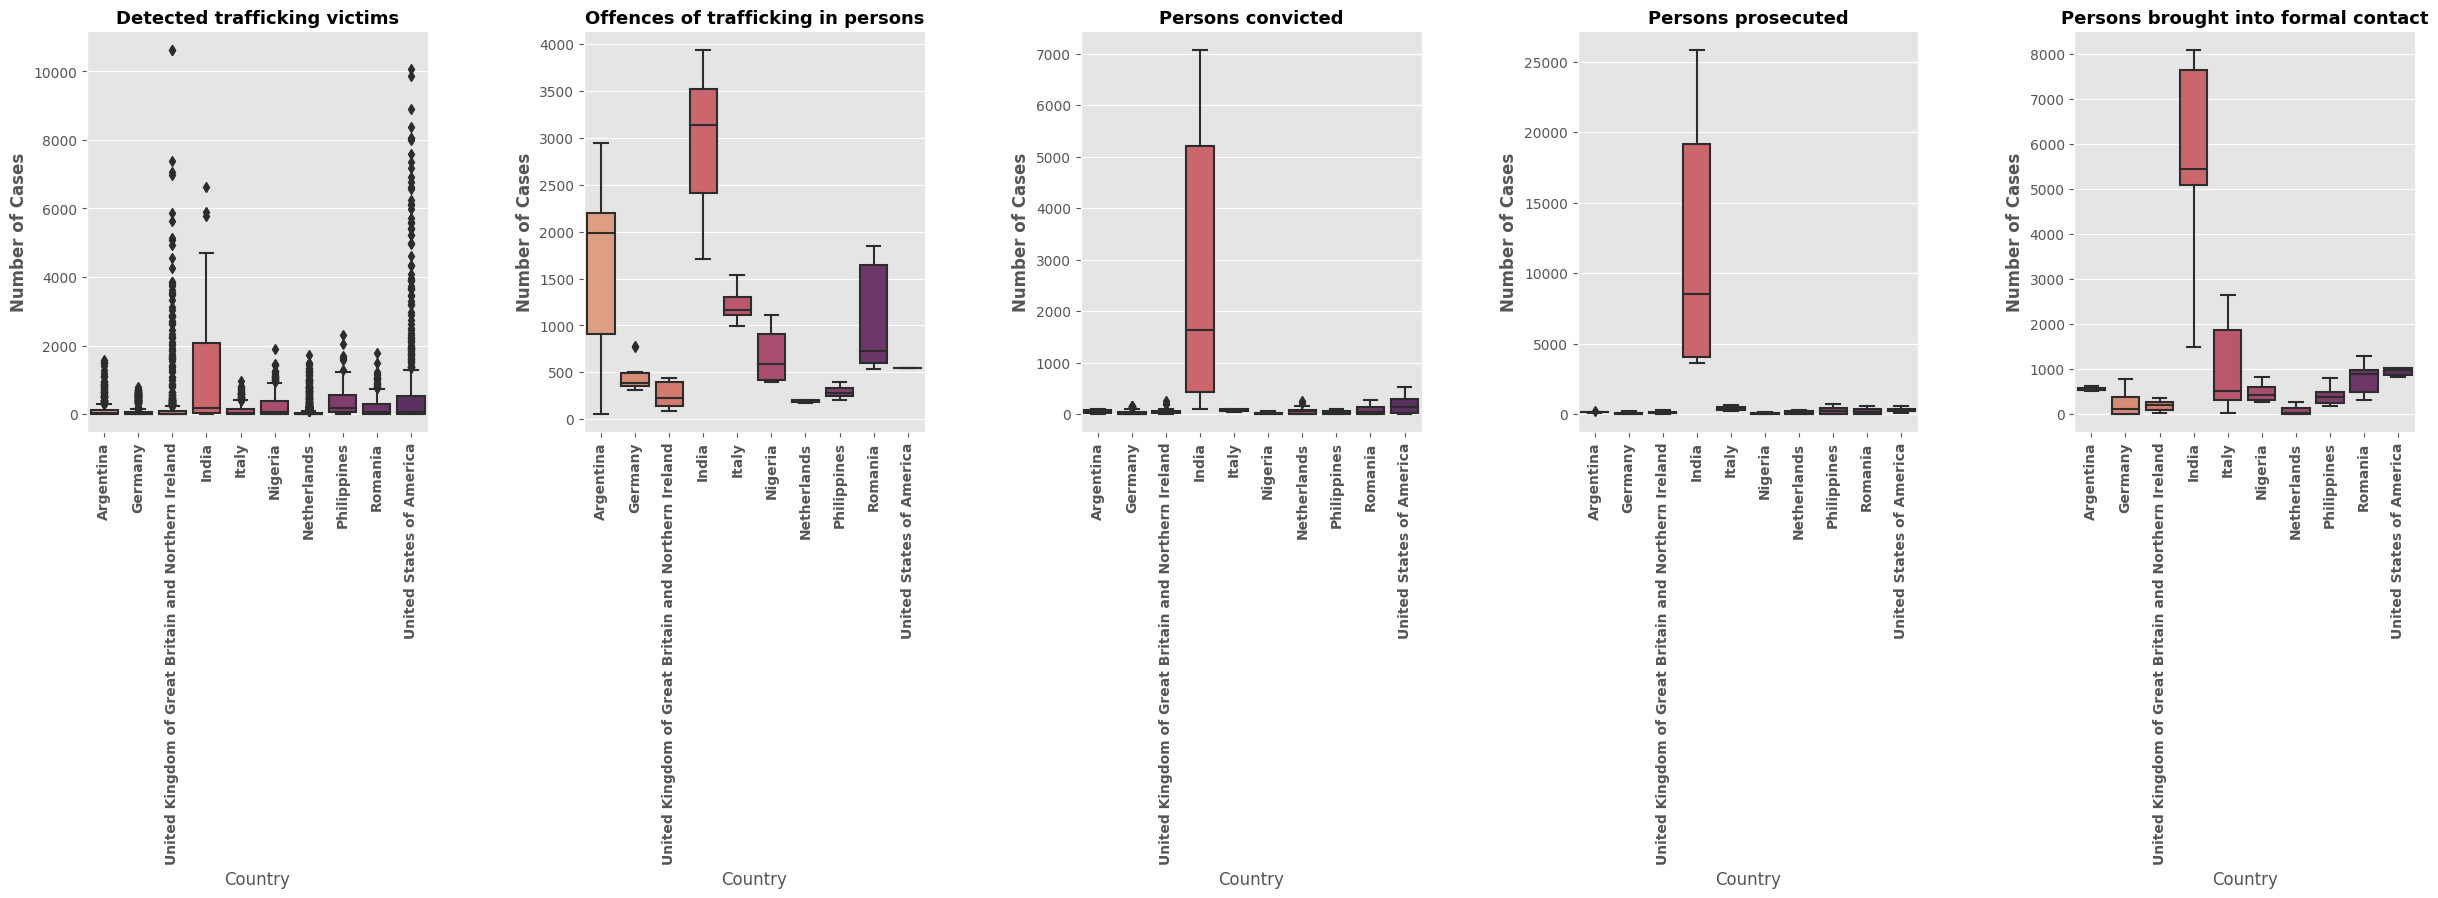

In [206]:
axs = sns.catplot(data=htf[htf['Country'].isin(country_origins)], col='Indicator', x='Country', y='Value', kind='box', sharey=False, palette='flare')
for ax in axs.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='bold')
    ax.set_ylabel("Number of Cases", fontweight='bold' )
    ax.set_title(ax.get_title().replace("Indicator = ", "").strip(), fontweight='bold', fontsize=13 )
    
axs.tight_layout() 

## **Distribution of Number of Trafficking Victims**

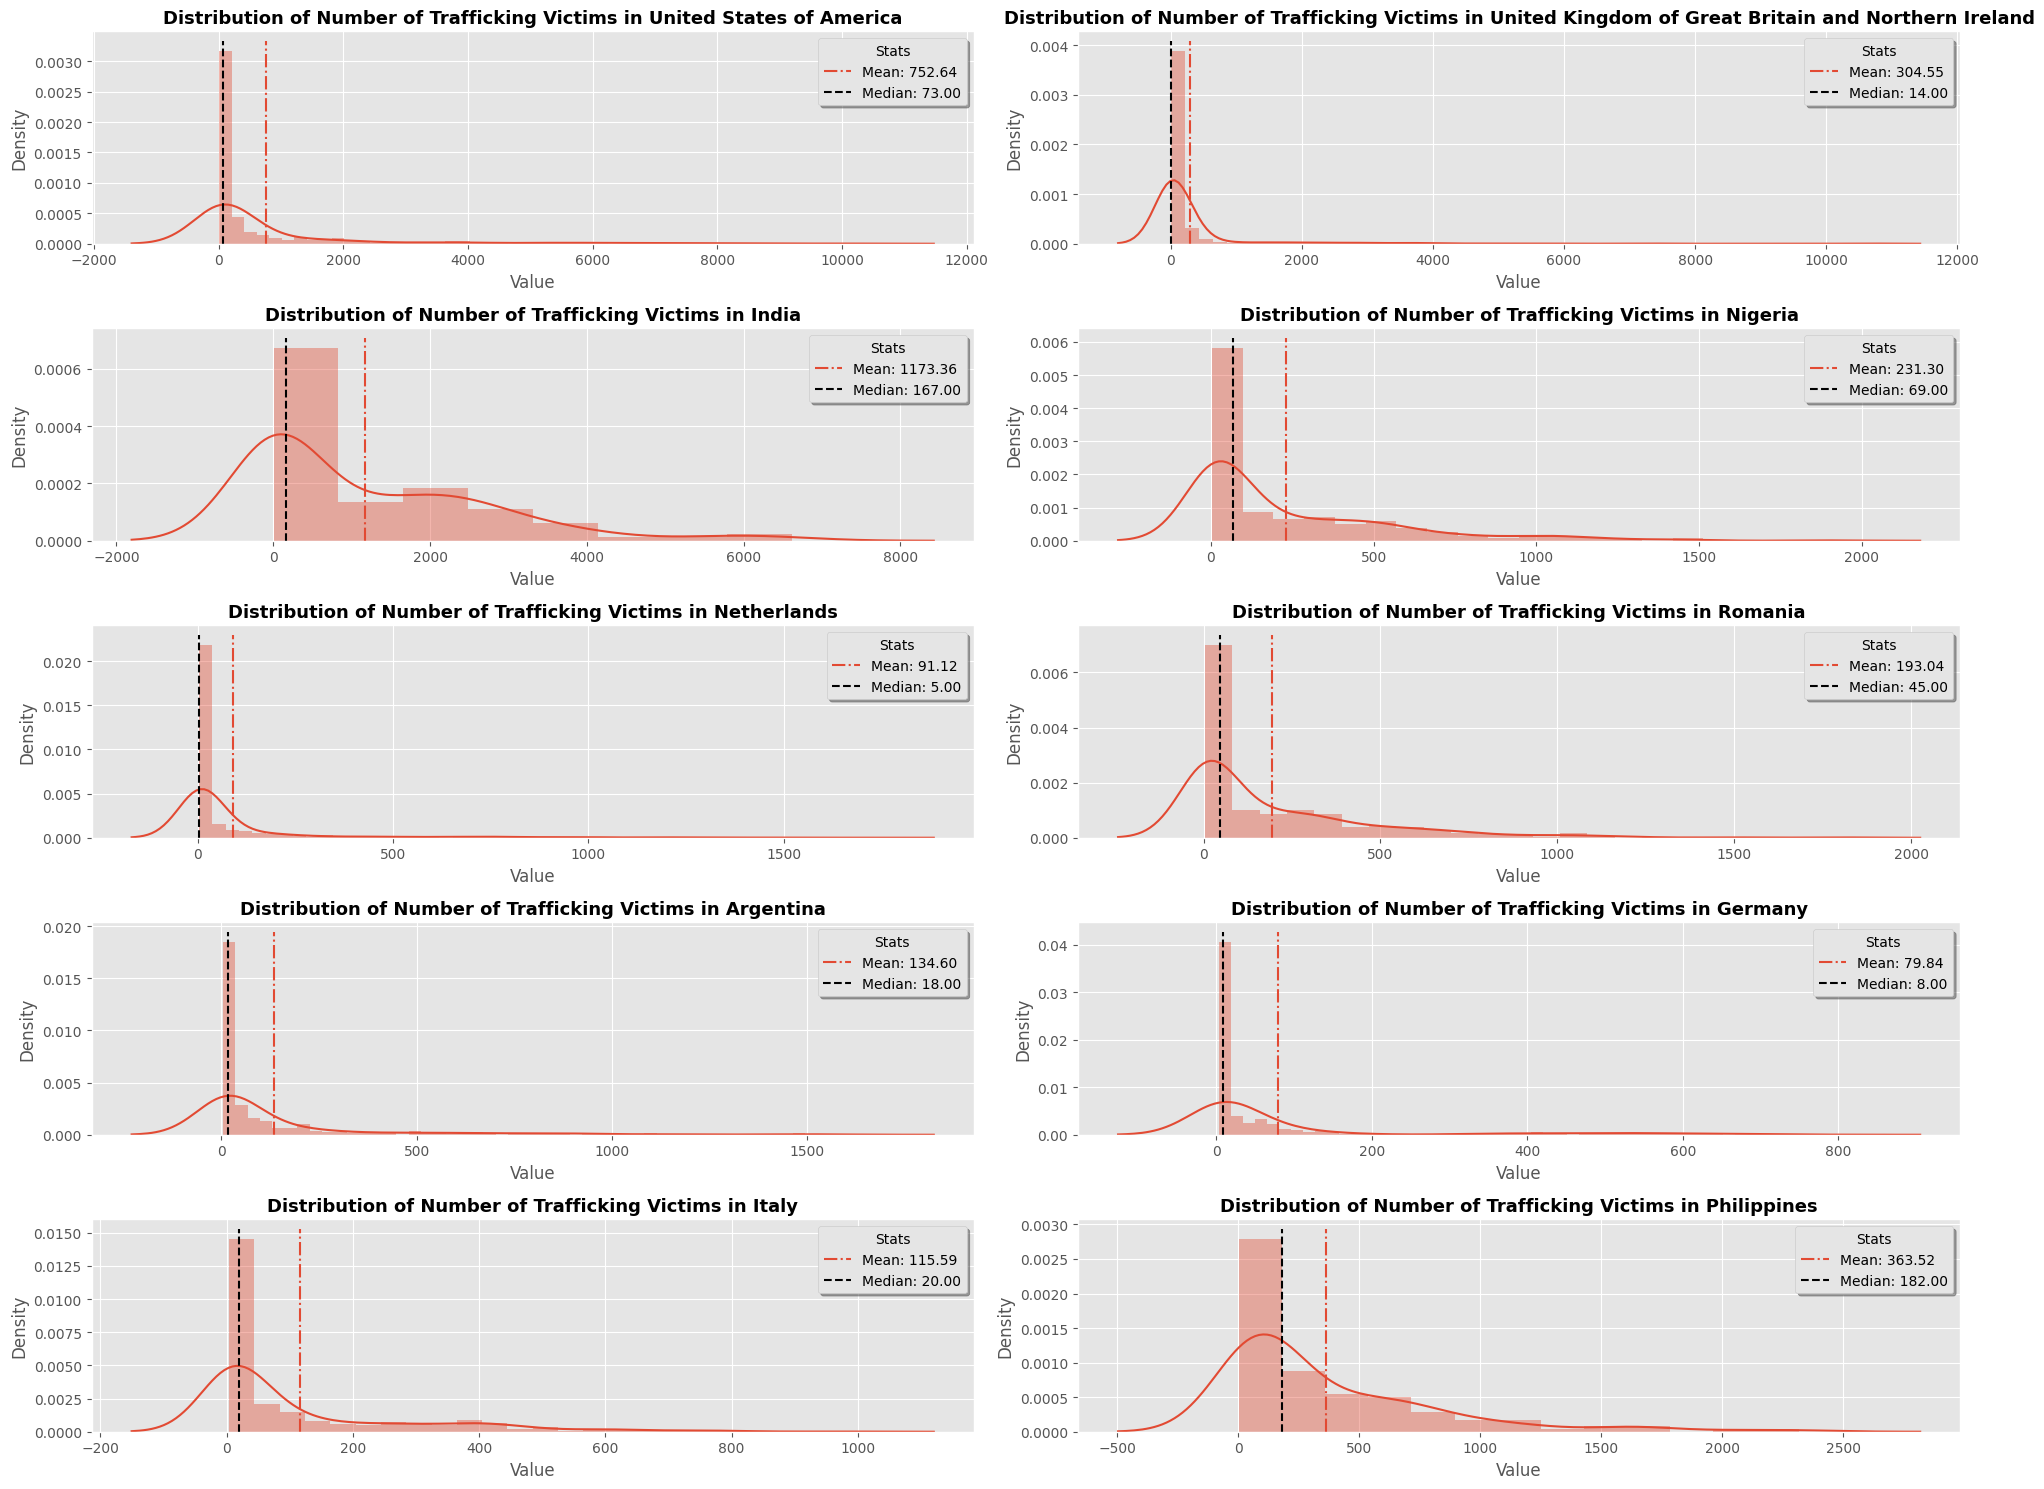

In [215]:
fig = plt.figure(figsize=(20,15)) 

for index,country in enumerate(country_origins, 1):
    ax = fig.add_subplot(5,2,index)
    df: 'Series' = htf.query(f"Country == '{country}' and Indicator == 'Detected trafficking victims'  ")['Value']
    sns.distplot( df, ax=ax )
    
    ax.set_title("Distribution of Number of Trafficking Victims in %s" % (country), fontweight='bold', fontsize=13)
    mean: float = df.mean() 
    median: float = df.median() 
    ymin,ymax = ax.get_ylim() 

    ax.vlines(mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.2f}", linestyle="-.")
    ax.vlines(median, ymin=ymin, ymax=ymax, label=f"Median: {median:.2f}", linestyle="--", color='black')
    ax.legend(title="Stats", fancybox=True, shadow=True) 
    
plt.tight_layout()

In [217]:
# Total Number of Trafficking Victims By Country, Years 
indicators: List[str] = htf['Indicator'].unique().tolist() 

## **Number of Trafficking Victims By Country**

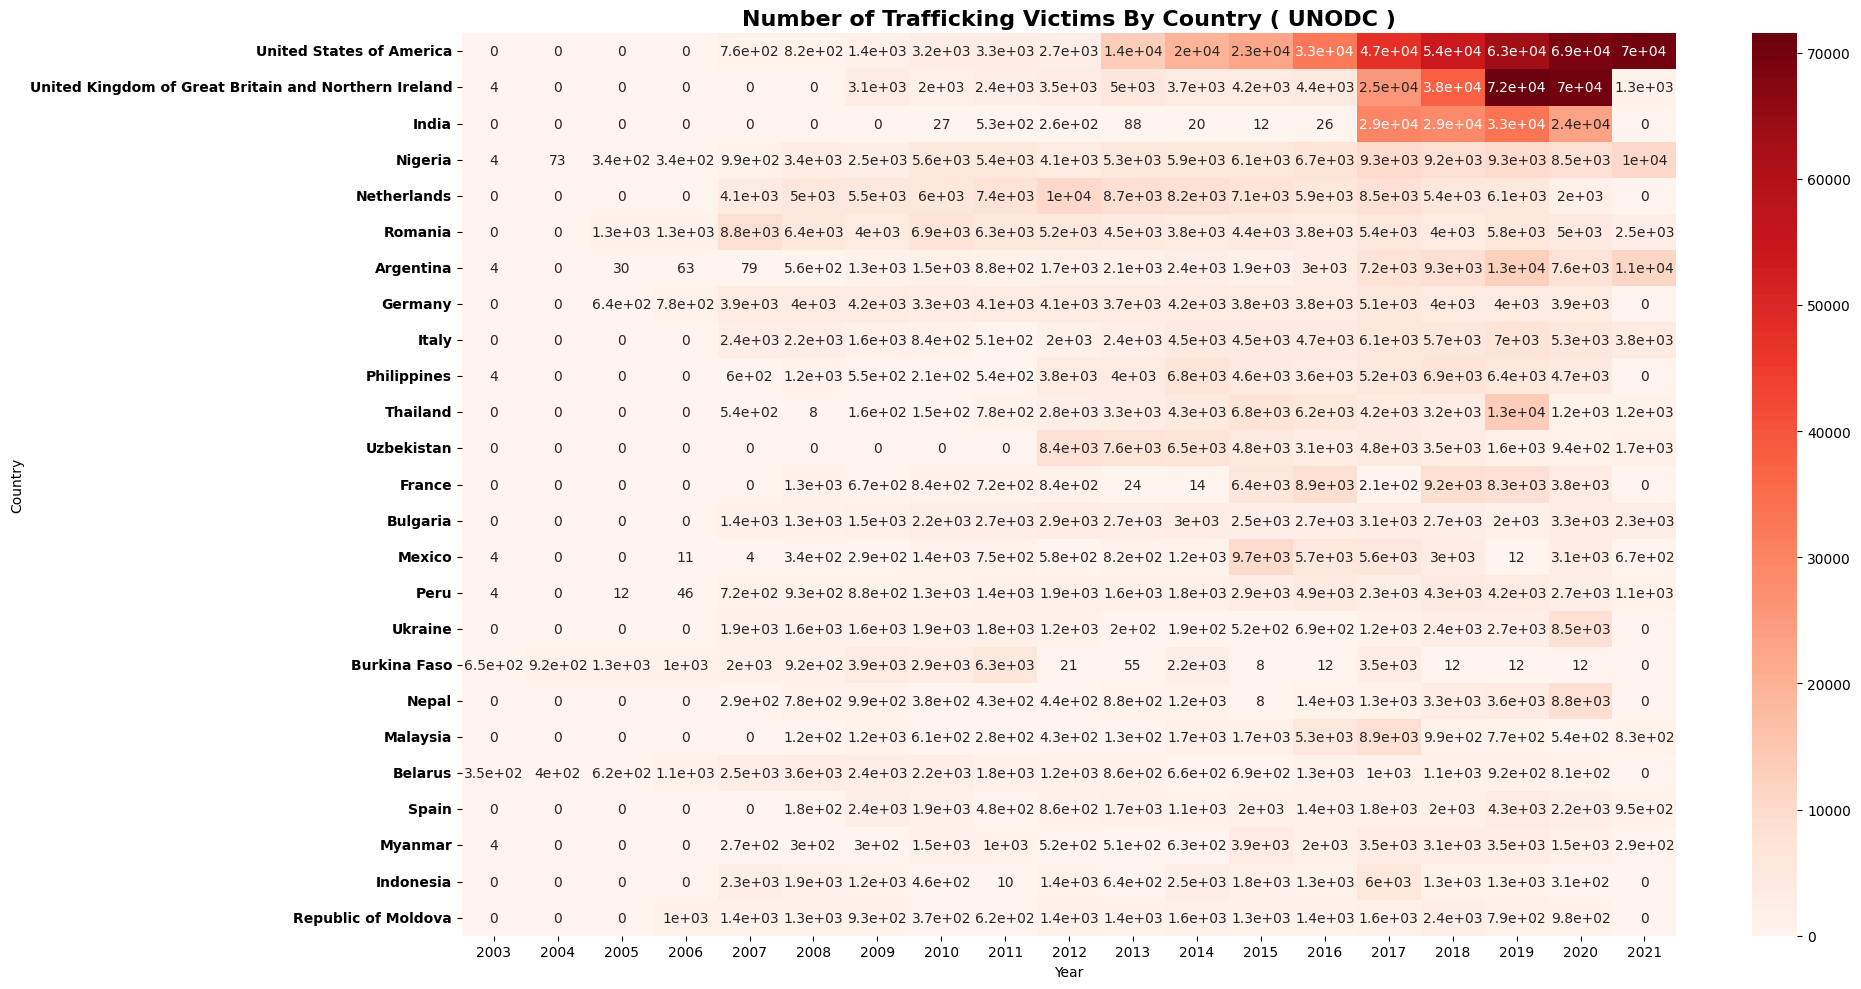

In [153]:
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot() 
sns.heatmap(htf.query("Indicator == 'Detected trafficking victims' ").groupby(['Year', 'Country'])['Value'].sum().unstack("Year").replace({np.nan:0.0}).loc[country_origins],
            ax=ax, 
            cmap=ListedColormap(sns.color_palette(palette='Reds', n_colors=100)), 
            annot=True
           )  # UNODC 

ax.set_title("Number of Trafficking Victims By Country ( UNODC )" , fontweight='bold', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.tight_layout() 

## **Additional Information** 
- **Note**: `Languages`, `Religions`

In [109]:
additinal_info: 'DataFrame' = pd.read_csv(os.path.join(DATASET_PATH, "AllCountries.csv") )
country_info: 'DataFrame' = pd.DataFrame(additinal_info.index.tolist()[:-14][1:], columns=additinal_info.index.tolist()[:-14][0] )
country_info.head()

,ROG3,Ctry,PoplPeoples,CntPeoples,CntPeoplesLR,PoplPeoplesLR,JPScaleCtry,ROL3OfficialLanguage,OfficialLang,RLG3Primary,ReligionPrimary,PercentChristianity,PercentEvangelical,10_40Window,ROG2,Continent,RegionCode,RegionName,PercentUrbanized,LiteracyRate,ISO3,Population
0,AF,Afghanistan,42135000,70,68,42133000,1,pbt,"Pashto, Southern",6,Islam,0.01717568505688,0.014293101193637,Y,ASI,Asia,5,"Asia, Central",27,43,AFG,42240000
1,AL,Albania,2800000,15,3,39000,2,aln,"Albanian, Gheg",6,Islam,33.677355517469,0.61188788975755,Y,EUR,Europe,9,"Europe, Eastern and Eurasia",64,98,ALB,2832000
2,AG,Algeria,45521000,38,34,45487000,1,arb,"Arabic, Standard",6,Islam,0.076112587236723,0.045811593588587,Y,AFR,Africa,6,"Africa, North and Middle East",75,81,DZA,45606000
3,AQ,American Samoa,43000,9,1,800,5,smo,Samoan,1,Christianity,95.422429497083,25.196447606216,N,SOP,Oceania,1,Australia and Pacific,87,97,ASM,44000
4,AN,Andorra,79000,10,2,1200,3,cat,Catalan,1,Christianity,90.595400299926,1.364684693558,N,EUR,Europe,10,"Europe, Western",88,100,AND,80000


In [219]:
country_info.groupby(['Ctry','ReligionPrimary']).size().unstack('ReligionPrimary').replace({np.nan:0.0}).head(25)

ReligionPrimary,Buddhism,Christianity,Ethnic Religions,Hinduism,Islam,Non-Religious
Ctry,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,1.0,0.0
Albania,0.0,0.0,0.0,0.0,1.0,0.0
Algeria,0.0,0.0,0.0,0.0,1.0,0.0
American Samoa,0.0,1.0,0.0,0.0,0.0,0.0
Andorra,0.0,1.0,0.0,0.0,0.0,0.0
Angola,0.0,1.0,0.0,0.0,0.0,0.0
Anguilla,0.0,1.0,0.0,0.0,0.0,0.0
Antigua and Barbuda,0.0,1.0,0.0,0.0,0.0,0.0
Argentina,0.0,1.0,0.0,0.0,0.0,0.0


## **CDE** 
- `CodeBook`

In [48]:
pd.DataFrame(list(map(lambda item: (item.split("–")[0].strip(), item.split("–")[1].strip()), filter(lambda item: len(item) > 0  , open(os.path.join( DATASET_PATH, "HumanTraffickingCodeBook.txt") ,"r" ).read().split("\n")[1:] ))), columns=['Columns', 'Description'])

,Columns,Description
0,DATA_YEAR,The year in which the incident occurred.
1,ORI,ORIGINATING AGENCY IDENTIFIER (ORI) - This identifies the agency in which the offense occurred.
2,PUB_AGENCY_NAME,Agency name as it appears in FBI UCR Publications.
3,PUB_AGENCY_UNIT,The specific unit name for which a Publication Agency report UCR data as.
4,AGENCY_TYPE_NAME,"Type of agency that reports UCR data (city/county/federal agency, etc)."
5,STATE_ABBR,This is the state abbreviation.
6,STATE_NAME,Full name of the state.
7,DIVISION_NAME,The geographic division in which the agency is located.
8,COUNTY_NAME,The name of the county within the state.
9,REGION_NAME,Geographic region in which the agency is located.


- **Load Dataset**

In [15]:
cde_df: 'DataFrame' = pd.read_csv( os.path.join(DATASET_PATH, "HT_2013_2022.csv") ) # US Cases 
cde_df['COUNTY'] = cde_df.apply(lambda row: "%s,%s" % (row['COUNTY_NAME'], row['STATE_ABBR']), axis=1)
states_lookup: Dict = dict(cde_df[['STATE_ABBR','STATE_NAME']].sort_values(by='STATE_ABBR').drop_duplicates().apply(lambda row: (row['STATE_ABBR'], row['STATE_NAME']), axis=1).tolist())
cde_df.head()

,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,COUNTY_NAME,REGION_NAME,POPULATION_GROUP_CODE,POPULATION_GROUP_DESC,OFFENSE_SUBCAT_ID,OFFENSE_NAME,OFFENSE_SUBCAT_NAME,ACTUAL_COUNT,UNFOUNDED_COUNT,CLEARED_COUNT,JUVENILE_CLEARED_COUNT,COUNTY
0,2013,MO0950000,St. Louis County Police Department,NaN,County,MO,Missouri,West North Central,ST LOUIS,Midwest,9A,"MSA counties 100,000 or over",HTCSA,Human Trafficking,Commercial Sex Acts,6,0.0,6,0,"ST LOUIS,MO"
1,2013,OH0020000,Allen,NaN,County,OH,Ohio,East North Central,ALLEN,Midwest,9C,"MSA counties from 10,000 thru 24,999",HTCSA,Human Trafficking,Commercial Sex Acts,1,0.0,1,0,"ALLEN,OH"
2,2013,OH0020000,Allen,NaN,County,OH,Ohio,East North Central,ALLEN,Midwest,9C,"MSA counties from 10,000 thru 24,999",HTIS,Human Trafficking,Involuntary Servitude,1,0.0,0,0,"ALLEN,OH"
3,2013,TN0320100,Morristown,NaN,City,TN,Tennessee,East South Central,"HAMBLEN, JEFFERSON",South,4,"Cities from 25,000 thru 49,999",HTCSA,Human Trafficking,Commercial Sex Acts,1,0.0,1,0,"HAMBLEN, JEFFERSON,TN"
4,2013,TNMPD0000,Memphis,NaN,City,TN,Tennessee,East South Central,SHELBY,South,1B,"Cities from 500,000 thru 999,999",HTCSA,Human Trafficking,Commercial Sex Acts,3,0.0,2,0,"SHELBY,TN"


## **Distribution of Human Trafficking Cases in the United States**
1. Unfounded Count 
2. Actual Count
3. Cleared Count
4. Juvenile Cleared Count

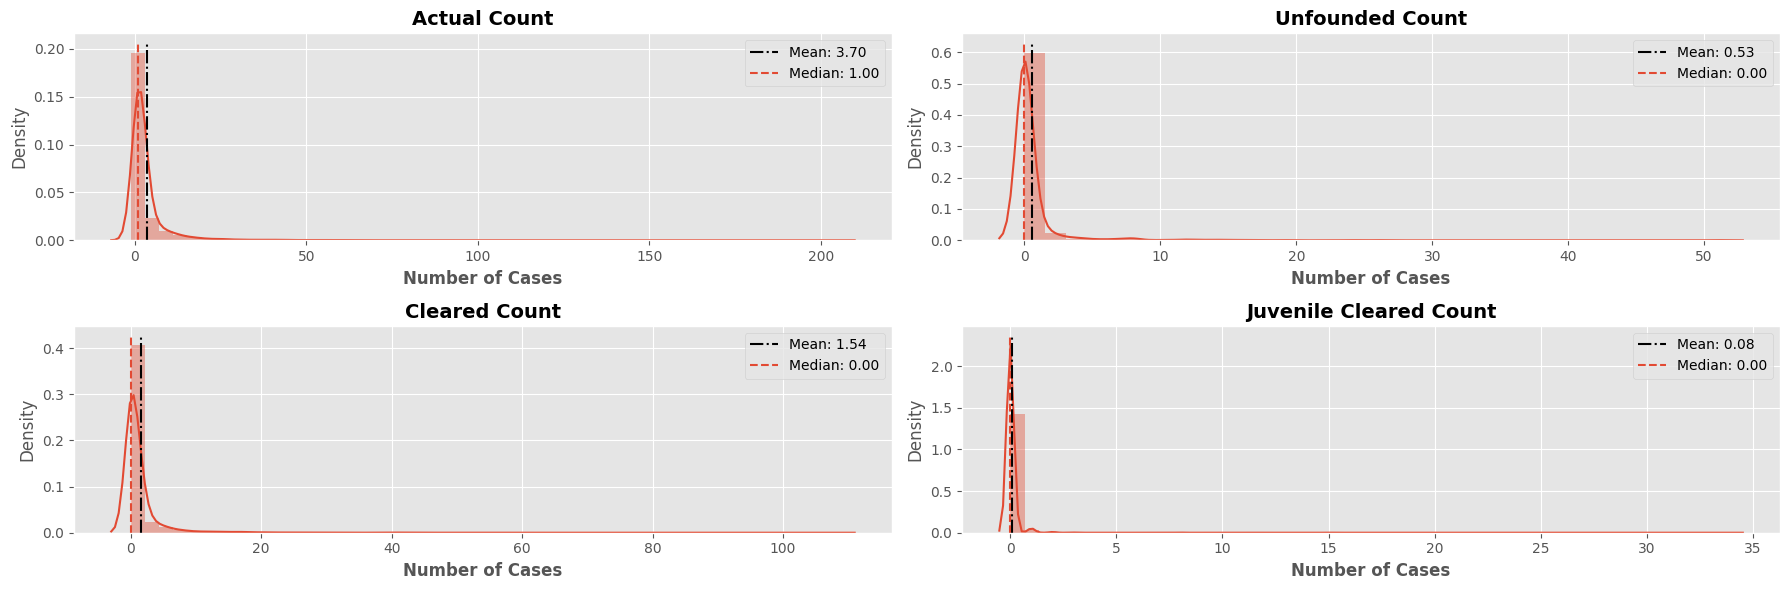

In [20]:
columns: List[str] = list(filter(lambda x: '_COUNT' in x, cde_df.columns.tolist()))
fig = plt.figure(figsize=(18,6)) 
for index,col in enumerate(columns, 1):

    ax = fig.add_subplot(2,2,index)
    curr_df: 'DataFrame' = cde_df[col] 
    sns.distplot(curr_df, ax=ax)
    ax.set_title(col.replace('_', ' ').title(), fontweight='bold', fontsize=14)
    ax.set_xlabel("Number of Cases", fontweight='bold')
    ymin,ymax = ax.get_ylim()

    mean: float = curr_df.mean() 
    median: float = curr_df.median()
    ax.vlines(x=mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.2f}", linestyle="-.", color='black') 
    ax.vlines(x=median, ymin=ymin, ymax=ymax, label=f"Median: {median:.2f}", linestyle="--") 
    ax.legend() 
plt.tight_layout()

## **Boxplot: Number of Offenses reported to the UCR Program by Region Name**

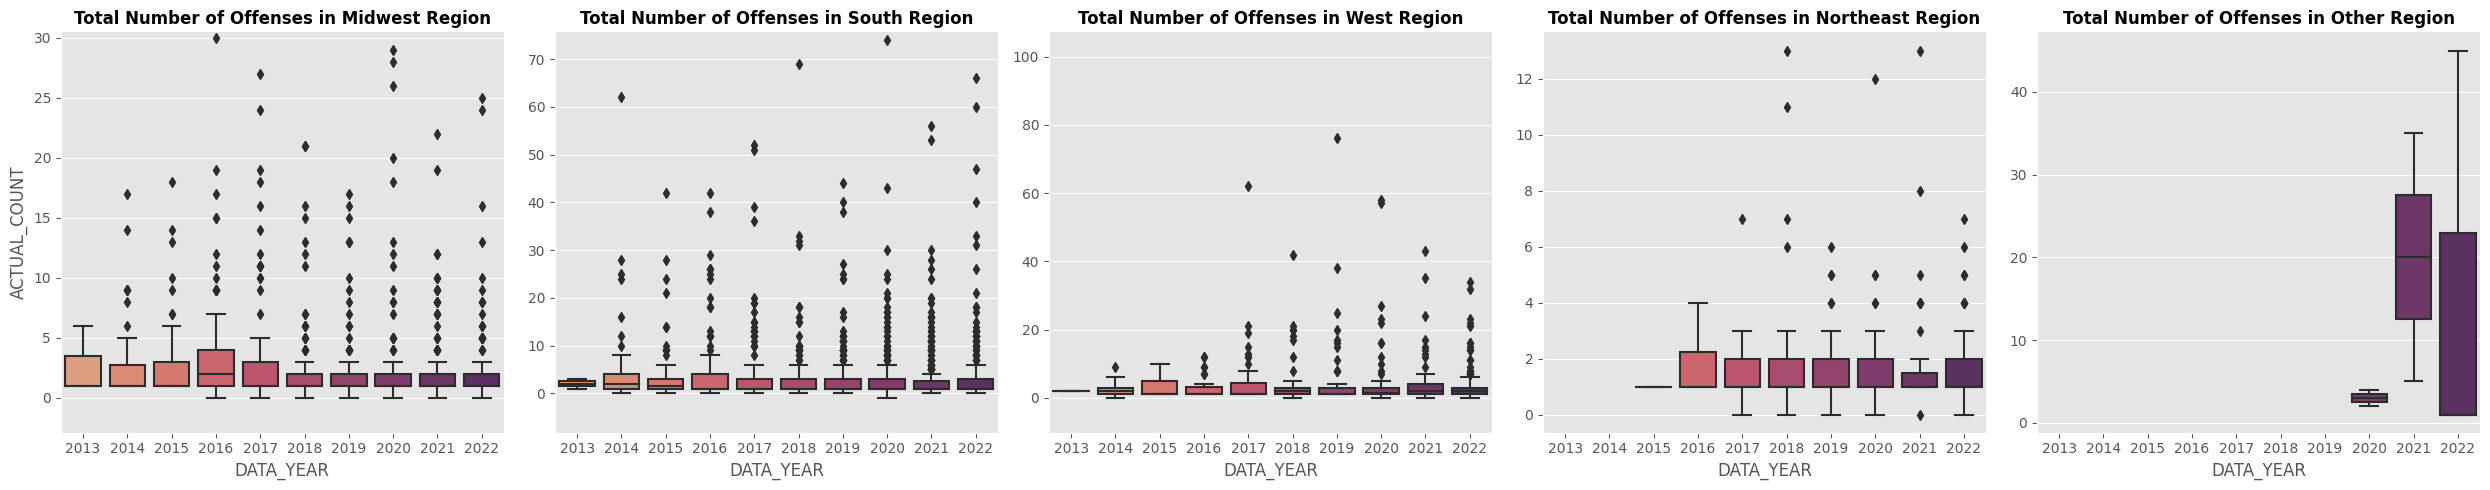

In [115]:
axs = sns.catplot(data=cde_df.query("REGION_NAME != 'U.S. Territories' "), col='REGION_NAME', x='DATA_YEAR', y='ACTUAL_COUNT', sharey=False, kind='box', palette='flare')
for index,ax in enumerate(axs.axes.ravel()):
    ymin,ymax = ax.get_ylim()
    ax.set_title( "Total Number of Offenses in %s Region" % (re.sub(".*.=", "", ax.get_title() ).strip() ) , fontweight='bold', fontsize=12)
    ax.set_ylim([ymin, ymax - (ymax * 0.5 ) if index < 3 else ymax ])

## **Total number of Human Trafficking reported to UCR Program** 

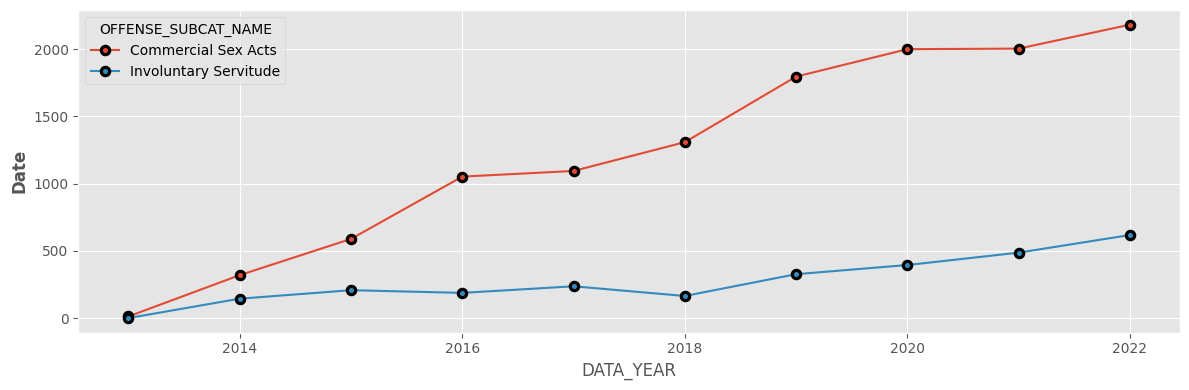

In [35]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
cde_df.groupby(['OFFENSE_SUBCAT_NAME', 'DATA_YEAR'])['ACTUAL_COUNT'].sum().unstack("OFFENSE_SUBCAT_NAME").plot(marker='o', mec='black', mew=2.3, ax=ax)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.set_ylabel("Date", fontweight='bold')
plt.tight_layout()

## **Total Number Reported Offenses by State**
- The graph below shows that Texas has the highest number of offenses reported to the UCR programs, followed by Nevada, Minnesota, Georgia, Florida, Wisconsin, Tennessee, and Colorado.


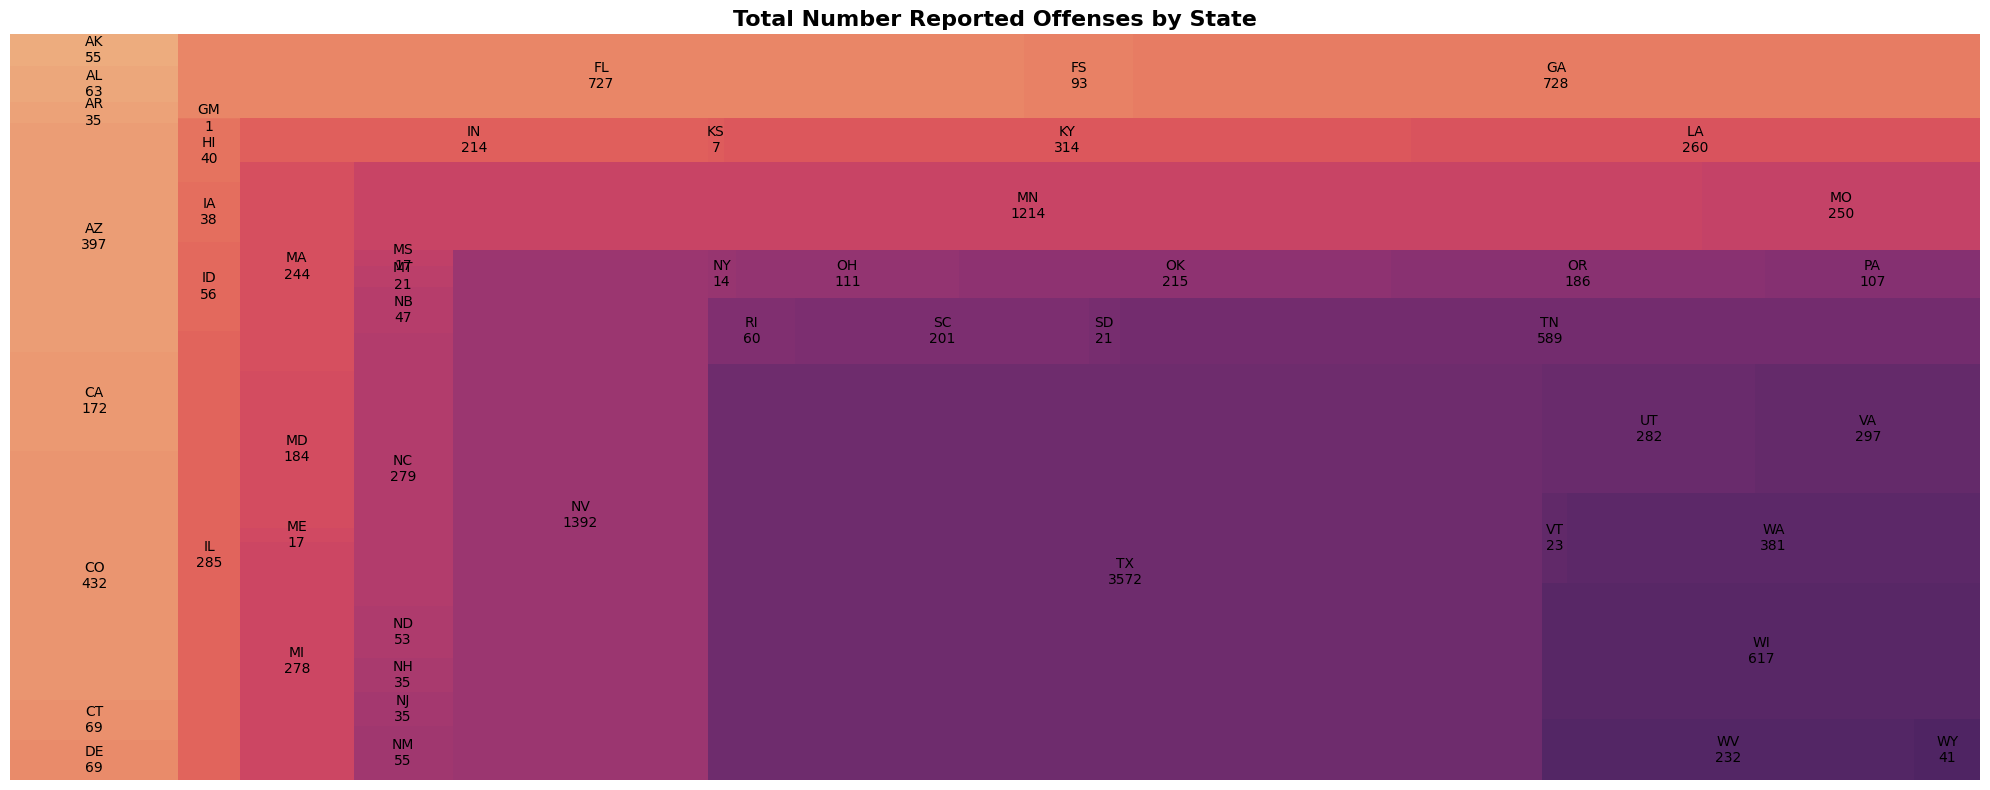

In [142]:
states, n_offenses = zip(*cde_df.groupby('STATE_ABBR')['ACTUAL_COUNT'].sum().to_dict().items())
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot() 

sq.plot(sizes=list(n_offenses), label=[ "%s\n%s" % (curr_state,n) for curr_state,n in zip(states, n_offenses) ], ax=ax, color=sns.color_palette(n_colors=52, palette='flare'))
ax.axis('off')
ax.set_title("Total Number Reported Offenses by State", fontweight='bold', fontsize=16)
ax.invert_yaxis()
plt.tight_layout()

## **Top 25 States: Total Number of Humman Trafficking Offenses**

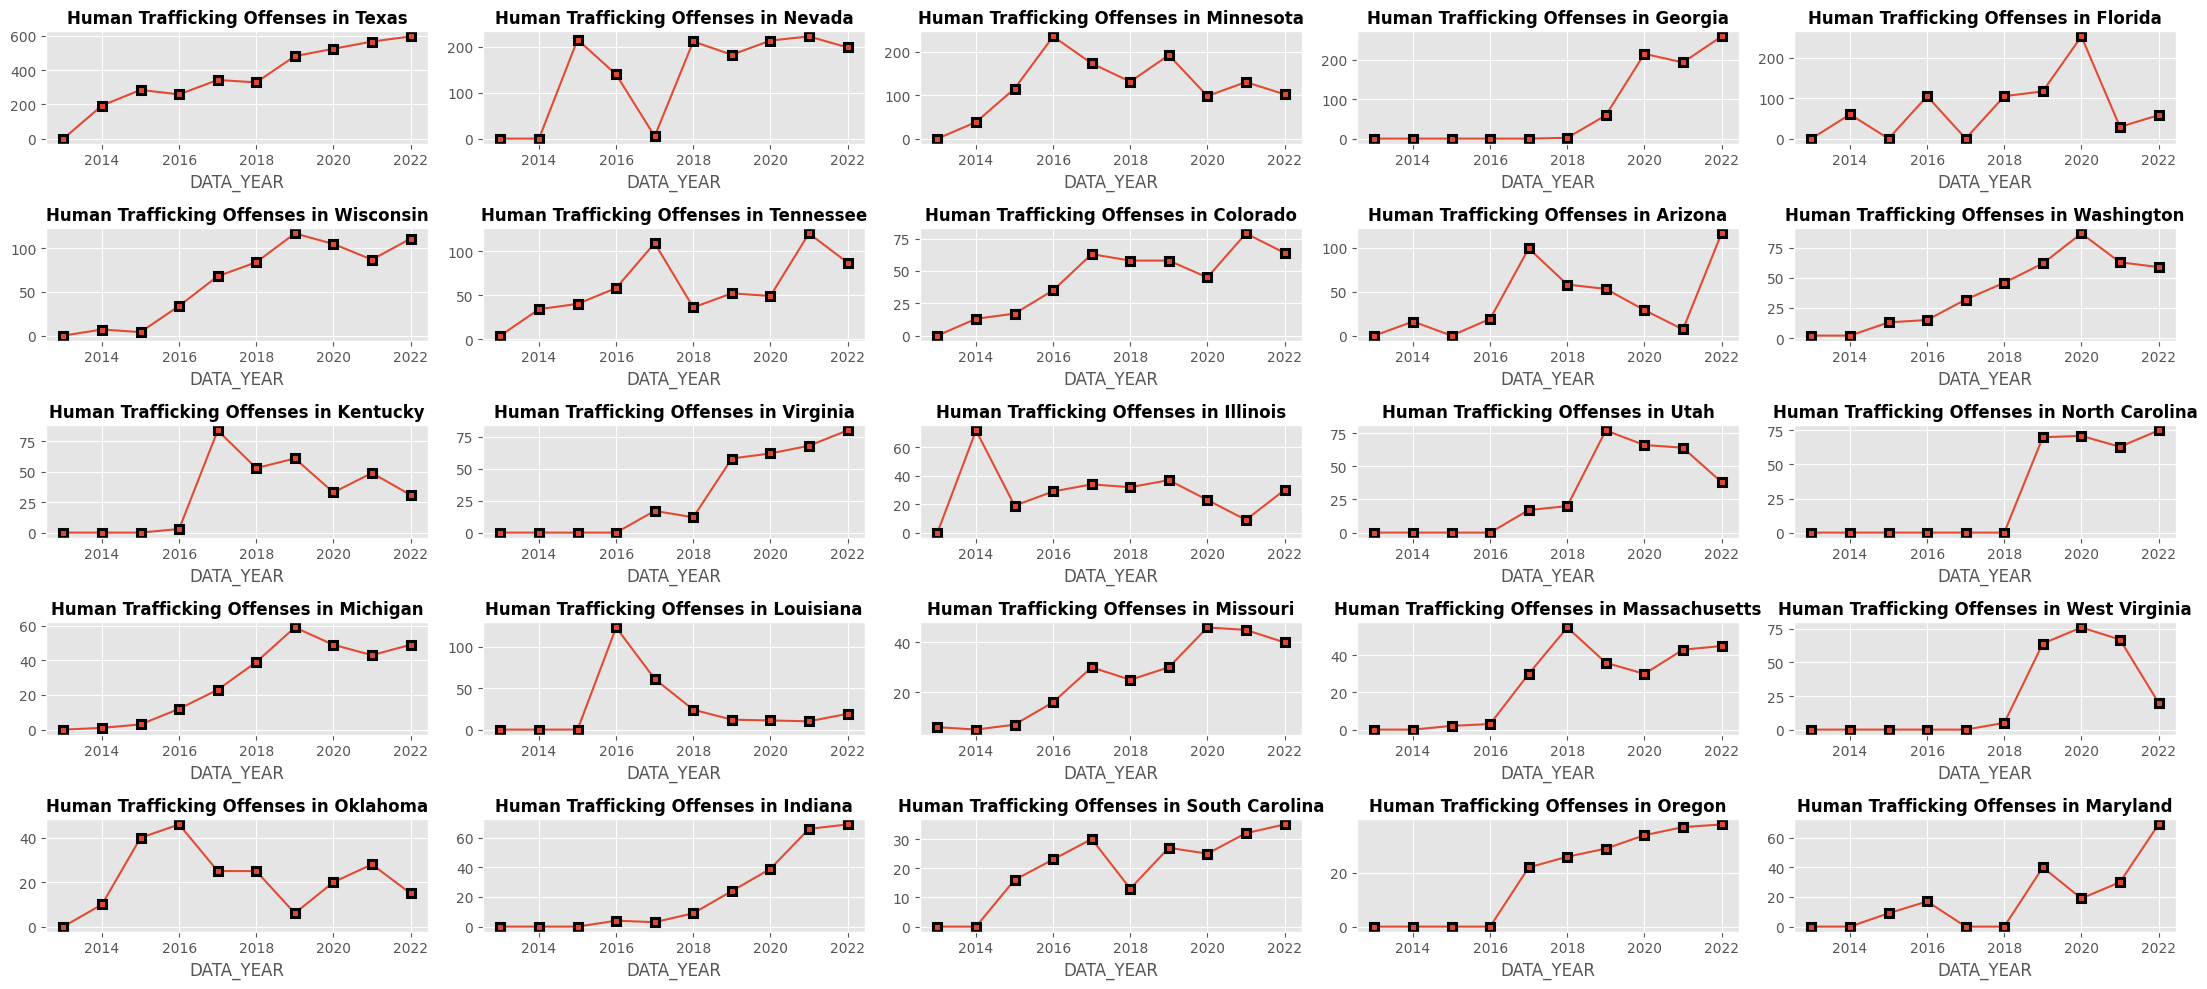

In [50]:
fig = plt.figure(figsize=(22,10)) 

ucr_program_summary: 'DataFrame' = pd.pivot_table(data=cde_df, columns='STATE_NAME', index='DATA_YEAR', values='ACTUAL_COUNT', aggfunc='sum').replace({np.nan:0.0})
for index, state in enumerate(ucr_program_summary.sum(axis=0).sort_values(ascending=False).head(25).index.tolist(),1):
    ax = fig.add_subplot(5,5,index)
    ucr_program_summary[state].plot(ax=ax, marker='s', mec='black', mew=2.2)
    ax.set_title("Human Trafficking Offenses in %s" % (state), fontweight='bold', fontsize=12)

plt.tight_layout()

## **Total Number of Human Trafficking Offenses reported to the UCR Program vs. Number of cases that were Cleared/Closed by US Region**

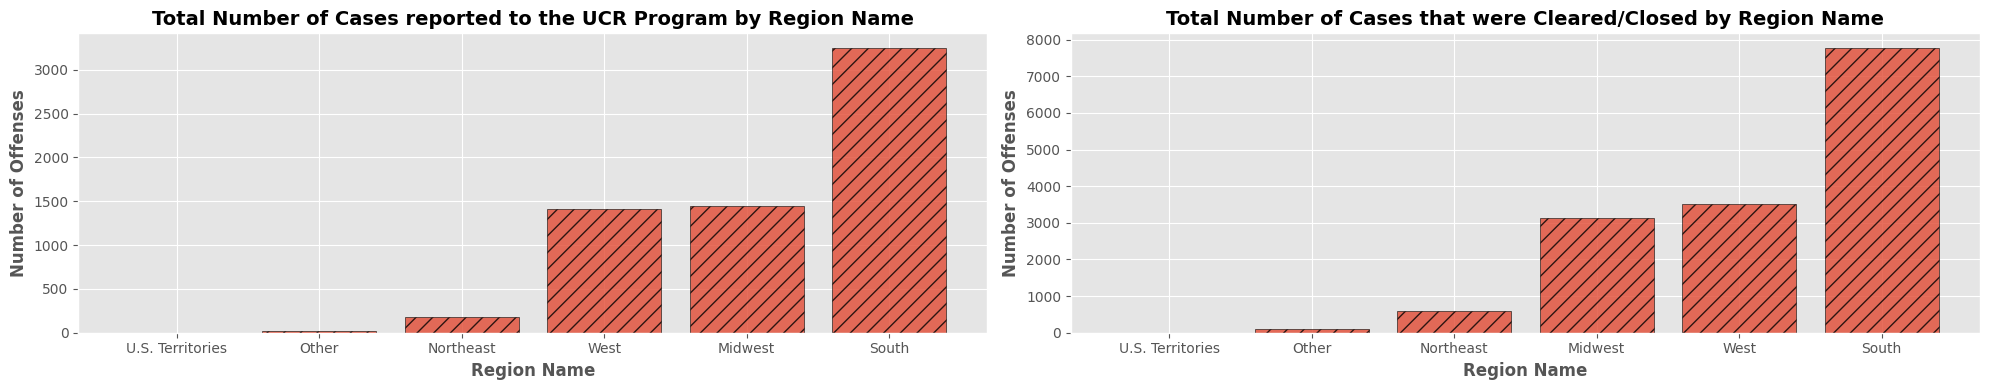

In [84]:
fig = plt.figure(figsize=(20,4))
region_names_one, total_cases_one = zip(*cde_df.groupby('REGION_NAME')['CLEARED_COUNT'].sum().sort_values().to_dict().items())
region_names_two, total_cases_two = zip(*cde_df.groupby('REGION_NAME')['ACTUAL_COUNT'].sum().sort_values().to_dict().items())

ax = fig.add_subplot(1,2,1)
ax.bar(x=list(region_names_one), height=list(total_cases_one), hatch='//', edgecolor='black', alpha=0.8)
ax.set_title("Total Number of Cases reported to the UCR Program by Region Name", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Offenses", fontweight='bold')
ax.set_xlabel("Region Name", fontweight='bold')

ax = fig.add_subplot(1,2,2)
ax.bar(x=list(region_names_two), height=list(total_cases_two), hatch='//', edgecolor='black', alpha=0.8)
ax.set_title("Total Number of Cases that were Cleared/Closed by Region Name", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Offenses", fontweight='bold')
ax.set_xlabel("Region Name", fontweight='bold')

plt.tight_layout()

## **Number of Offenses vs. Number of Cleared/Closed Cases by County,State**

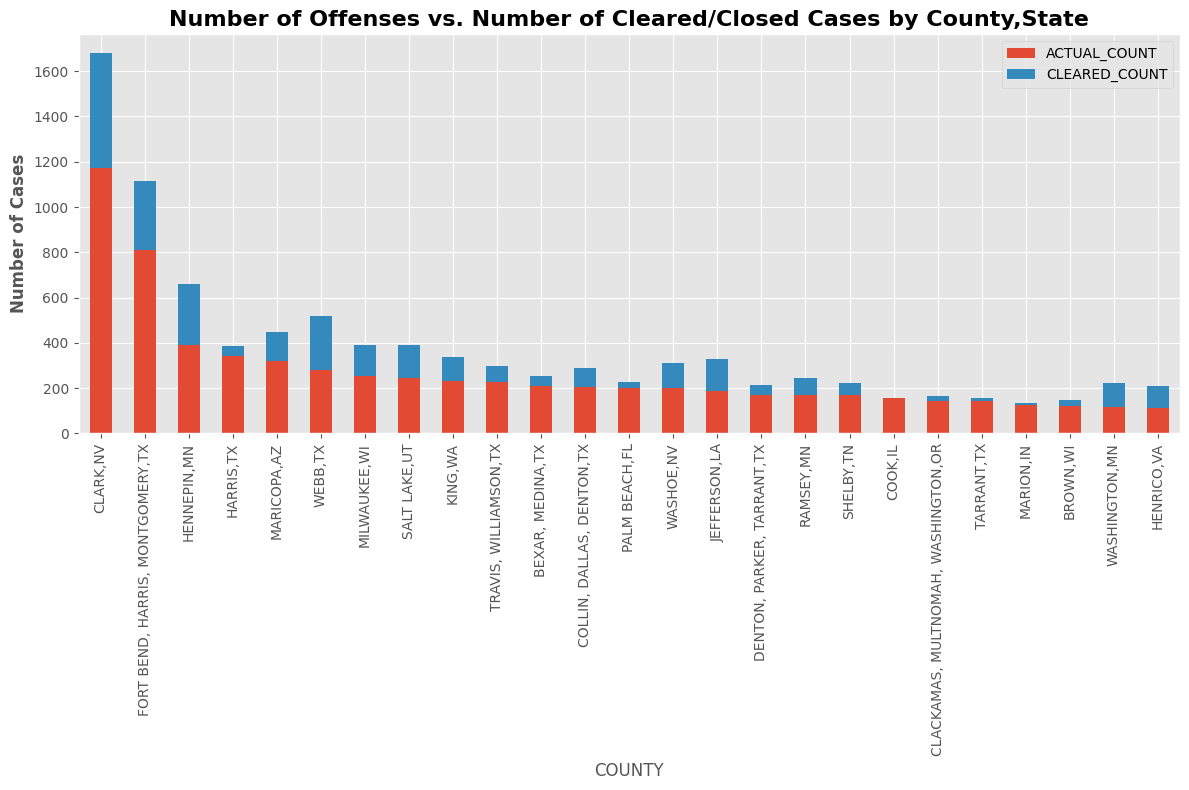

In [93]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
cde_df.groupby(['COUNTY'])[ ['ACTUAL_COUNT', 'CLEARED_COUNT'] ].sum().sort_values(['ACTUAL_COUNT', 'CLEARED_COUNT'] ,axis=0, ascending=False).head(25).plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.set_title("Number of Offenses vs. Number of Cleared/Closed Cases by County,State", fontweight='bold', fontsize=16)
plt.tight_layout()

# **Reported Crimes in Texas (NIBRS)** 

In [4]:
con: sqlite3 = sqlite3.connect("../datasets/Texas/texas.db")

## **Converting NIBRS Dataset into SQLite Format**

In [47]:
for item in os.listdir(dataset_path): 
    if 'csv' in item:
        print("[ \033[92m+\033[0m ] Converting %s -> %s" % (item, re.sub(r".csv", "", item).strip())  ) 
        pd.read_csv(os.path.join(dataset_path, item) ).to_sql(re.sub(r".csv", "", item).strip() , con=con, if_exists='append')

[ + ] Converting NIBRS_VICTIM.csv -> NIBRS_VICTIM
[ + ] Converting NIBRS_PROPERTY_DESC.csv -> NIBRS_PROPERTY_DESC
[ + ] Converting NIBRS_incident.csv -> NIBRS_incident
[ + ] Converting NIBRS_ARREST_TYPE.csv -> NIBRS_ARREST_TYPE
[ + ] Converting NIBRS_ARRESTEE_WEAPON.csv -> NIBRS_ARRESTEE_WEAPON
[ + ] Converting NIBRS_WEAPON_TYPE.csv -> NIBRS_WEAPON_TYPE
[ + ] Converting NIBRS_LOCATION_TYPE.csv -> NIBRS_LOCATION_TYPE
[ + ] Converting NIBRS_PROP_DESC_TYPE.csv -> NIBRS_PROP_DESC_TYPE
[ + ] Converting NIBRS_SUSPECTED_DRUG.csv -> NIBRS_SUSPECTED_DRUG
[ + ] Converting NIBRS_OFFENDER.csv -> NIBRS_OFFENDER
[ + ] Converting NIBRS_AGE.csv -> NIBRS_AGE
[ + ] Converting NIBRS_ETHNICITY.csv -> NIBRS_ETHNICITY
[ + ] Converting NIBRS_VICTIM_INJURY.csv -> NIBRS_VICTIM_INJURY
[ + ] Converting NIBRS_ASSIGNMENT_TYPE.csv -> NIBRS_ASSIGNMENT_TYPE
[ + ] Converting NIBRS_BIAS_MOTIVATION.csv -> NIBRS_BIAS_MOTIVATION
[ + ] Converting NIBRS_CRIMINAL_ACT_TYPE.csv -> NIBRS_CRIMINAL_ACT_TYPE
[ + ] Converting NIBRS

##  **NIBRS Tables**
- **Reported Years**: 2021, 2022 (Collected data before,during, and after Covid-19)

In [95]:
nibrs_tables: 'DataFrame' = pd.read_sql("SELECT name FROM sqlite_master WHERE type == 'table' " , con=con ) 
lookup_tbl: Dict = { tbl:pd.read_sql(f"SELECT * FROM {tbl} LIMIT 1", con=con).columns.tolist() for tbl in nibrs_tables['name'].tolist() }

nibrs_tables.sort_values(by='name', ascending=False)

,name
41,agencies
30,REF_STATE
31,REF_RACE
40,NIBRS_month
2,NIBRS_incident
5,NIBRS_WEAPON_TYPE
42,NIBRS_WEAPON
33,NIBRS_VICTIM_TYPE
27,NIBRS_VICTIM_OFFENSE
32,NIBRS_VICTIM_OFFENDER_REL


## **Query: Reported Crimes in Texas according to `NIBRS`**

In [5]:
query: str = """ 
SELECT 
    nv.data_year,
    nv.sex_code,
    ne.ethnicity_id, 
    ne.ethnicity_code AS `victim_ethnicity_code`, 
    ne.ethnicity_name AS `victim_ethnicity_name`,
    nwt.weapon_name, 
    nwt.weapon_code, 
    nwt.shr_flag, 
    no.num_premises_entered,
    no.method_entry_code,
    nat.activity_type_code,
    nat.activity_type_name, 
    nlt.location_name,
    ncat.criminal_act_id,
    ncat.criminal_act_name, 
    ncat.criminal_act_desc,
    ncat.criminal_act_code, 
    nsd.est_drug_qty, 
    nsd.drug_measure_type_id, 
    nsd.nibrs_suspected_drug_id, 
    nbl.bias_code,
    nbl.bias_category,
    nbl.bias_desc,
    nvt.victim_type_code,
    nvt.victim_type_name,
    na.arrestee_seq_num,
    na.arrest_date,
    na.arrest_type_id,
    na.multiple_indicator,
    na.offense_code,
    na.age_id,
    na.age_num,
    na.sex_code,
    na.race_id,
    na.ethnicity_id,
    na.resident_code,
    na.under_18_disposition_code,
    na.clearance_ind,
    na.age_range_low_num,
    na.age_range_high_num, 
    ni.cargo_theft_flag,
    ni.submission_date,
    ni.incident_date,
    ni.report_date_flag,
    ni.incident_hour,
    ni.cleared_except_id,
    ni.cleared_except_date,
    ni.incident_status,
    ni.data_home,
    ni.orig_format, 
    a.*  -- all agency attributes
    
FROM NIBRS_VICTIM nv 
JOIN NIBRS_VICTIM_INJURY nvi ON nvi.victim_id = nv.victim_id 
JOIN NIBRS_ETHNICITY ne ON ne.ethnicity_id = nv.ethnicity_id 
JOIN NIBRS_OFFENSE no ON no.incident_id = nv.incident_id
JOIN NIBRS_WEAPON nw ON nw.offense_id = no.offense_id
JOIN NIBRS_WEAPON_TYPE nwt ON nwt.weapon_id = nw.weapon_id
JOIN NIBRS_ACTIVITY_TYPE nat ON nat.activity_type_id = nv.activity_type_id
JOIN NIBRS_LOCATION_TYPE nlt ON nlt.location_id = no.location_id
JOIN NIBRS_CRIMINAL_ACT nca ON nca.offense_id = no.offense_id
JOIN NIBRS_CRIMINAL_ACT_TYPE ncat ON ncat.criminal_act_id = nca.criminal_act_id
JOIN NIBRS_PROPERTY np ON np.incident_id = nv.incident_id AND nv.data_year = np.data_year
JOIN NIBRS_SUSPECTED_DRUG nsd ON nsd.property_id = np.property_id AND nsd.data_year = np.data_year
JOIN NIBRS_DRUG_MEASURE_TYPE ndmt ON ndmt.drug_measure_type_id = nsd.drug_measure_type_id
JOIN NIBRS_BIAS_MOTIVATION nbm ON nbm.offense_id = no.offense_id AND nbm.data_year = no.data_year
JOIN NIBRS_BIAS_LIST nbl ON nbl.bias_id = nbm.bias_id
JOIN NIBRS_VICTIM_TYPE nvt ON nvt.victim_type_id = nv.victim_type_id
JOIN NIBRS_ARRESTEE na ON na.incident_id = nv.incident_id AND na.data_year = nv.data_year
JOIN NIBRS_incident ni ON ni.incident_id = no.incident_id
JOIN agencies a ON a.agency_id = ni.agency_id
"""
crimes_df: 'DataFrame' = pd.read_sql(query, con=con)
crimes_df = crimes_df.drop_duplicates() 
crimes_df['arrest_date'] = pd.to_datetime(crimes_df['arrest_date'])
crimes_df['month_name'] = crimes_df['arrest_date'].apply(lambda row: row.month_name() )
crimes_df['month'] = crimes_df['arrest_date'].apply(lambda row: row.month )
crimes_df['incident_date'] = pd.to_datetime( crimes_df['incident_date'])
crimes_df.index = np.arange(1, crimes_df.shape[0] + 1 )
crimes_df.head()

,data_year,sex_code,ethnicity_id,victim_ethnicity_code,victim_ethnicity_name,weapon_name,weapon_code,shr_flag,num_premises_entered,method_entry_code,activity_type_code,activity_type_name,location_name,criminal_act_id,criminal_act_name,criminal_act_desc,criminal_act_code,est_drug_qty,drug_measure_type_id,nibrs_suspected_drug_id,bias_code,bias_category,bias_desc,victim_type_code,victim_type_name,arrestee_seq_num,arrest_date,arrest_type_id,multiple_indicator,offense_code,age_id,age_num,sex_code,race_id,ethnicity_id,resident_code,under_18_disposition_code,clearance_ind,age_range_low_num,age_range_high_num,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,orig_format,index,yearly_agency_id,agency_id,data_year,ori,legacy_ori,covered_by_legacy_ori,direct_contributor_flag,dormant_flag,dormant_year,reporting_type,ucr_agency_name,ncic_agency_name,pub_agency_name,pub_agency_unit,agency_status,state_id,state_name,state_abbr,state_postal_abbr,division_code,division_name,region_code,region_name,region_desc,agency_type_name,population,submitting_agency_id,sai,submitting_agency_name,suburban_area_flag,population_group_id,population_group_code,population_group_desc,parent_pop_group_code,parent_pop_group_desc,mip_flag,pop_sort_order,summary_rape_def,pe_reported_flag,male_officer,male_civilian,male_officer+male_civilian,female_officer,female_civilian,female_officer+female_civilian,officer_rate,employee_rate,nibrs_cert_date,nibrs_start_date,nibrs_leoka_start_date,nibrs_ct_start_date,nibrs_multi_bias_start_date,nibrs_off_eth_start_date,covered_flag,county_name,msa_name,publishable_flag,participated,nibrs_participated,month_name,month
1,2022,M,20,N,Not Hispanic or Latino,Handgun,12,t,None,None,10,Traffic Pursuits and Stops,Highway/Road/Alley/Street/Sidewalk,6,Possessing/Concealing,Possessing/Concealing,P,0.06,3,14378518,88,None/Unknown,None (no bias),L,Law Enforcement Officer,1,2022-06-20,1,N,520,23,20,M,20,20,None,None,None,20.0,NaN,f,2022-12-16 15:27:46.304,2022-06-19,f,23.0,6,None,ACCEPTED,None,F,76,188472021,18847,2021,TX0190500,TX0190500,None,N,N,None,I,TEXARKANA,TEXARKANA PD,Texarkana,None,A,48,Texas,TX,TX,7,West South Central,3,South,Region III,City,36208,23393,TXUCR0001,Texas Department of Public Safety Crime Information Bureau Uniform Crime Reporting,N,8,4,"Cities from 25,000 thru 49,999",4,"Cities from 25,000 thru 49,999",N,8,None,Y,79.0,5.0,84.0,8.0,7.0,15.0,2.4,2.7,1997-01-01,2021-01-01,2021-01-01,None,2021-04-01,None,N,BOWIE,"Texarkana, TX-AR",Y,Y,Y,June,6
2,2022,M,20,N,Not Hispanic or Latino,Handgun,12,t,None,None,10,Traffic Pursuits and Stops,Highway/Road/Alley/Street/Sidewalk,6,Possessing/Concealing,Possessing/Concealing,P,0.06,3,14378518,88,None/Unknown,None (no bias),L,Law Enforcement Officer,1,2022-06-20,1,N,520,23,20,M,20,20,None,None,None,20.0,NaN,f,2022-12-16 15:27:46.304,2022-06-19,f,23.0,6,None,ACCEPTED,None,F,78,188472022,18847,2022,TX0190500,TX0190500,None,N,N,None,I,TEXARKANA,TEXARKANA PD,Texarkana,None,A,48,Texas,TX,TX,7,West South Central,3,South,Region III,City,35859,23393,TXUCR0001,Texas Department of Public Safety Crime Information Bureau Uniform Crime Reporting,N,8,4,"Cities from 25,000 thru 49,999",4,"Cities from 25,000 thru 49,999",N,8,None,Y,78.0,5.0,83.0,6.0,6.0,12.0,2.3,2.6,1997-01-01,2021-01-01,2021-01-01,None,2021-04-01,None,N,BOWIE,"Texarkana, TX-AR",Y,Y,Y,June,6
3,2022,M,20,N,Not Hispanic or Latino,Handgun,12,t,None,None,10,Traffic Pursuits and Stops,Highway/Road/Alley/Street/Sidewalk,6,Possessing/Concealing,Possessing/Concealing,P,0.06,3,14378518,88,None/Unknown,None (no bias),L,Law Enforcement Officer,2,2022-06-20,1,N,520,21,18,M,20,20,None,None,None,18.0,NaN,f,2022-12-16 15:27:46.304,2022-06-19,f,23.0,6,None,ACCEPTED,None,F,76,188472021,18847,2021,TX0190500,TX0190500,None,N,N,None,I,TEXARKANA,TEXARKANA PD,Texarkana,None,A,48,Texas,TX,TX,7,West South Central,3,South,Region III,City,36208,23393,TXUCR0001,Texas Depar

## **Distribution of the Arrestee Age** 

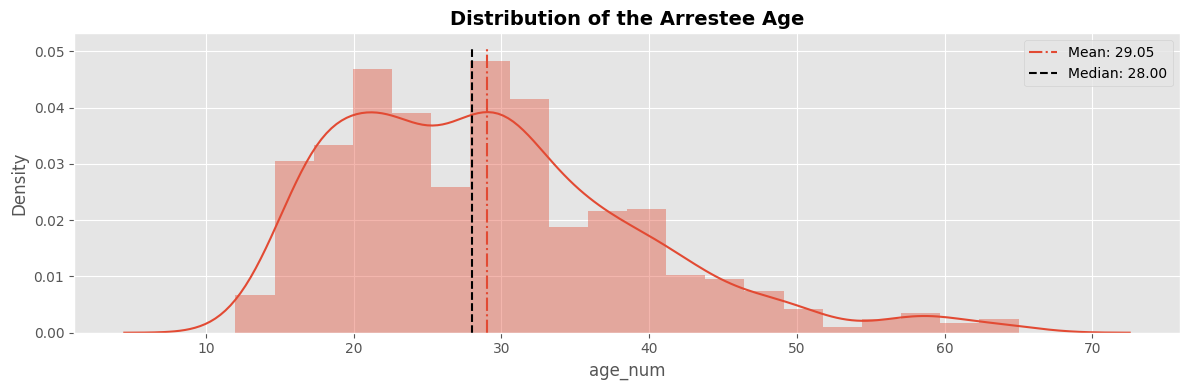

In [168]:
fig = plt.figure(figsize=(12,4) )
ax = fig.add_subplot() 
sns.distplot( crimes_df['age_num'],ax=ax )
ax.set_title("Distribution of the Arrestee Age",fontweight='bold', fontsize=14)
ymin,ymax = ax.get_ylim() 

mean: float = crimes_df['age_num'].mean()
median: float = crimes_df['age_num'].median() 

ax.vlines(x=mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.2f}", linestyle='-.')
ax.vlines(x=median, ymin=ymin, ymax=ymax, label=f"Median: {median:.2f}", linestyle='--', color='black' )
ax.legend() 
plt.tight_layout() 

## **Trends in Arrest Made**

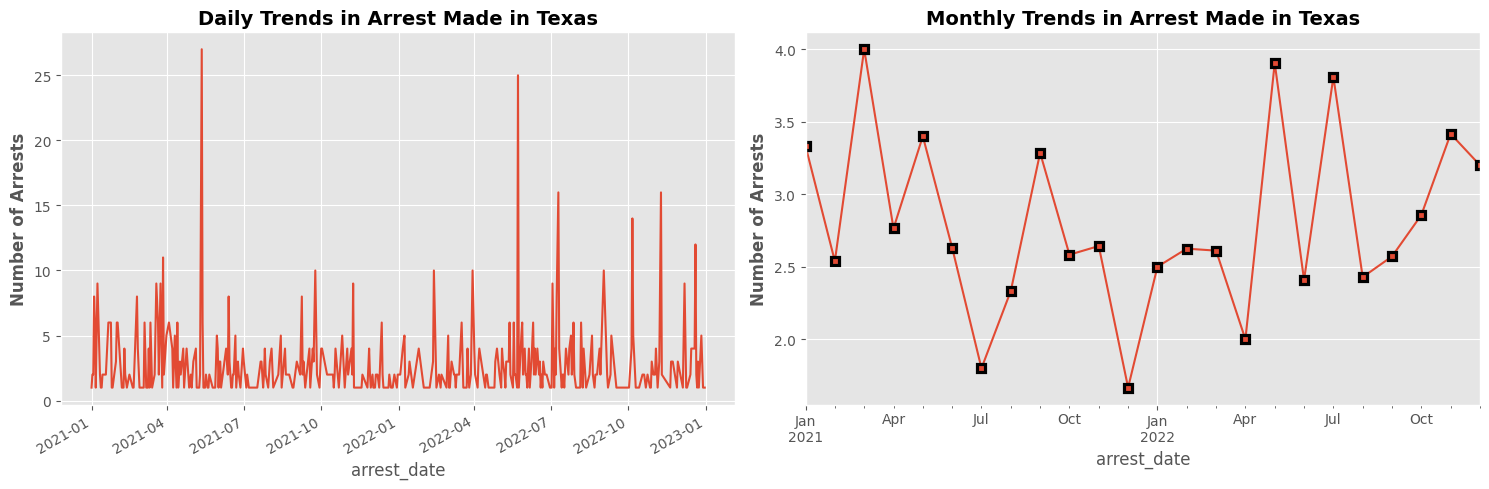

In [162]:
fig = plt.figure(figsize=(15,5)) 
ax = fig.add_subplot(1,2,1)
crimes_df.groupby('arrest_date').size().sort_index().plot(ax=ax) 
ax.set_title("Daily Trends in Arrest Made in Texas", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Arrests", fontweight='bold')

ax = fig.add_subplot(1,2,2)
crimes_df.groupby('arrest_date').size().sort_index().resample('M').mean().plot(ax=ax, marker='s', mec='black', mew=2.3,) 
ax.set_title("Monthly Trends in Arrest Made in Texas", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Arrests", fontweight='bold')

plt.tight_layout() # incident date, number of arrest based on activity_type_name

## **Trends in Criminal Activities in `TX`**

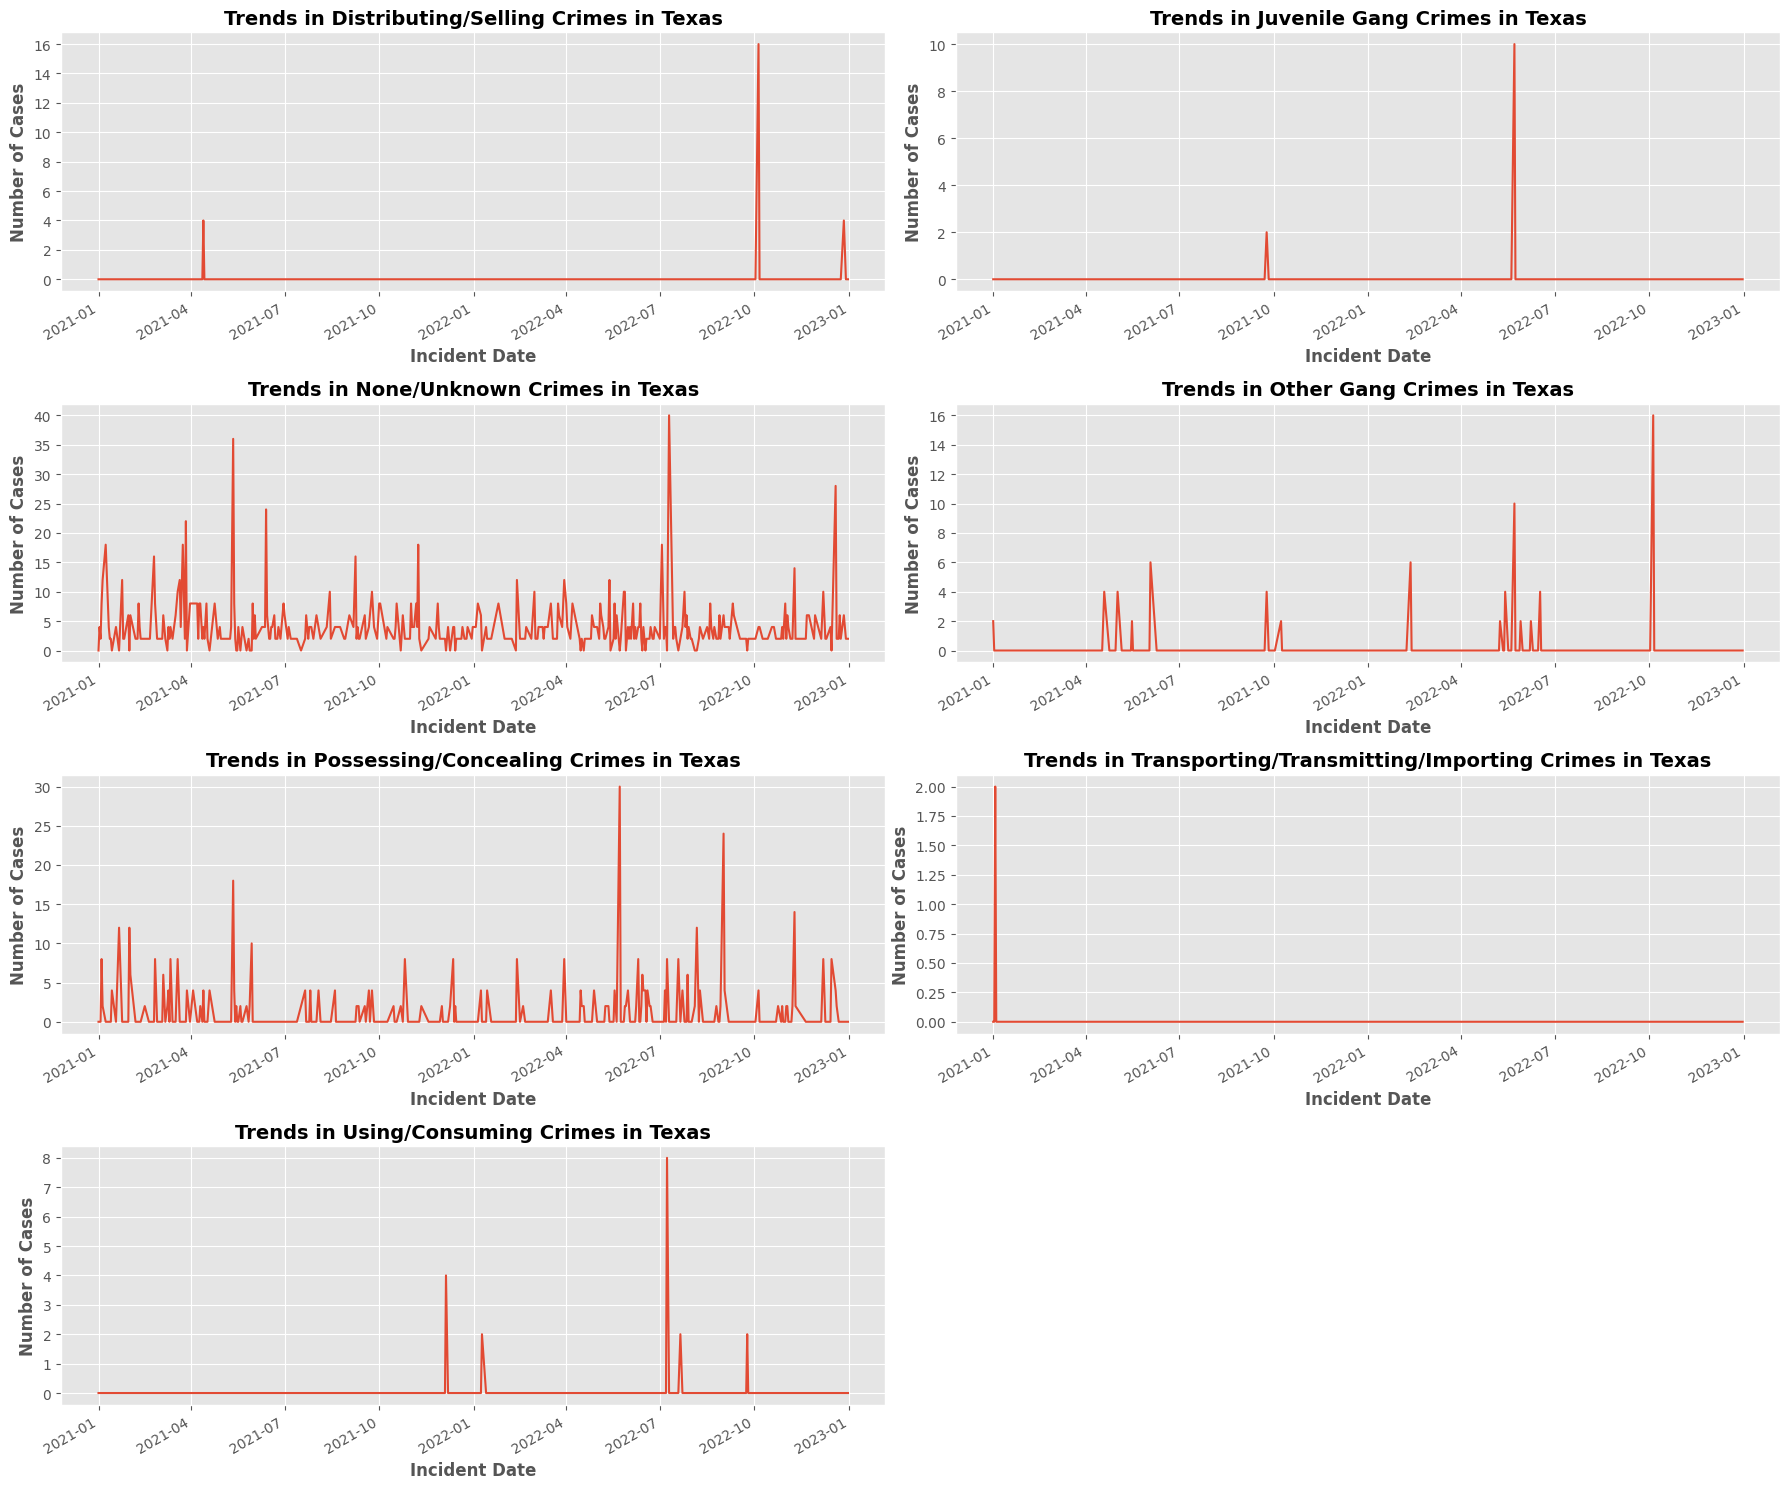

In [58]:
fig = plt.figure(figsize=(18,15))

crime_trends: 'DataFrame' = crimes_df.groupby(['incident_date','criminal_act_name']).size().unstack('criminal_act_name').replace({np.nan:0.0})
for index,crime_type in enumerate(crimes_df['criminal_act_name'].sort_values().unique().tolist(),1): 
    ax = fig.add_subplot(4,2,index)
    crime_trends[crime_type].plot(ax=ax)
    ax.set_title(f"Trends in %s Crimes in Texas" % (crime_type.title()), fontweight='bold', fontsize=14 )
    ax.set_ylabel("Number of Cases", fontweight='bold')
    ax.set_xlabel("Incident Date", fontweight='bold')

plt.tight_layout() 

## **Types of Crimes and Weapons used During the Incident** 

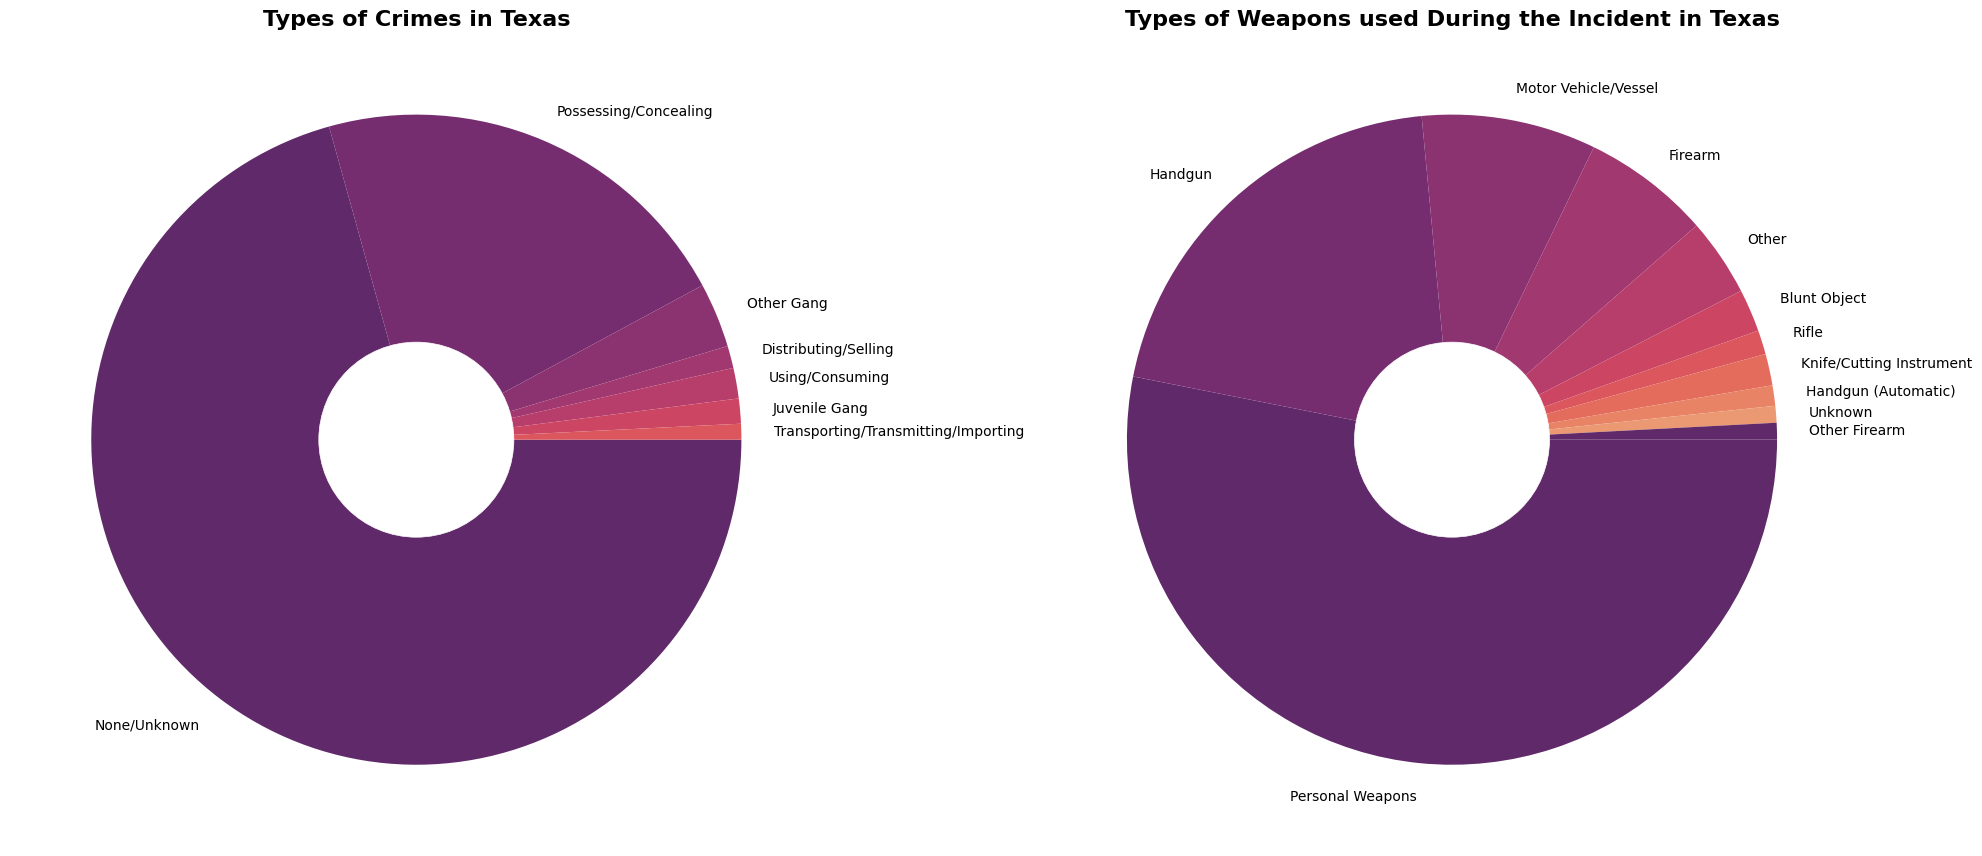

In [109]:
crime_names, freqs = zip(*crimes_df['criminal_act_name'].value_counts().to_dict().items()) 
weapons_types, weap_freqs = zip(*crimes_df['weapon_name'].value_counts().to_dict().items())

fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(1,2,1)
ax.set_title("Types of Crimes in Texas", fontweight='bold', fontsize=16 )
ax.pie(x=list( freqs[:4] ) + (np.array(freqs[4:]) + 15 ).tolist() , labels=list(crime_names), colors=sns.color_palette(n_colors=10, palette='flare_r'), counterclock=False, rotatelabels=False)
plt.gcf().gca().add_artist(plt.Circle((0,0), radius=0.3, color='white' ) )

ax = fig.add_subplot(1,2,2)
ax.set_title("Types of Weapons used During the Incident in Texas", fontweight='bold', fontsize=16 )
ax.pie(x=list(weap_freqs[:-4] ) + (np.array(weap_freqs[-4:] ) + 10 ).tolist() , labels=list(weapons_types), colors=sns.color_palette(n_colors=10, palette='flare_r'), counterclock=False, rotatelabels=False)
plt.gcf().gca().add_artist(plt.Circle((0,0), radius=0.3, color='white' ) )
plt.tight_layout() 


In [62]:
# incident_date, activity_type_name,  weapon_name
# TODO: Unknown Crimes? and weaps used during the incident

## **Assaults on Law Enforcement Officers**
- Build Assults Events History DB
- Explore Methods 

In [58]:
con2: 'SQLite' = sqlite3.connect("../datasets/leoka_assignment_activities.db")
for csv_file in os.listdir("../datasets/"):
    if 'LEOKA_ASSIGNMENT_ACTIVITY' in csv_file: 
        print(f"[ \033[92m+\033[0m ] Converting {csv_file} to sqlite3 ...")
        pd.read_csv(os.path.join("../datasets", csv_file ) ).to_sql("LEOKA_ASSIGNMENT_ACTIVITY", con=con2, if_exists='append')

con3: 'SQLite' = sqlite3.connect("../datasets/assault_time_weapon_injury.db")
_ = pd.read_csv("../datasets/LEOKA_ASSAULT_TIME_WEAPON_INJURY_1995_2022.csv").to_sql("LEOKA_ASSAULT_TIME_WEAPON_INJURY_1995_2022", con=con3, if_exists='append')

[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2020_2022.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2015_2019.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2010_2014.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2005_2009.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2000_2004.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_1995_1999.csv to sqlite3 ...


## **Information about LEOKA - Assignment and activity data**

In [68]:
con2: 'SQLite' = sqlite3.connect("../datasets/leoka_assignment_activities.db")
query: str = """
SELECT 
    laa.data_year,
    laa.pub_agency_name,
    laa.pub_agency_unit,
    laa.state_abbr,
    laa.division_name,
    laa.region_name,
    laa.agency_type_name,
    laa.population_group_desc,
    laa.county_name,
    laa.activity_id,
    laa.activity_name,
    laa.two_officer_vehicle_actual,
    laa.one_officer_alone_actual,
    laa.one_officer_assisted_actual,
    laa.det_spe_ass_alone_actual,
    laa.det_spe_ass_assisted_actual,
    laa.other_alone_actual,
    laa.other_assisted_actual,
    laa.firearm_actual,
    laa.knife_actual,
    laa.hands_fists_feet_actual,
    laa.other_actual,
    laa.cleared_count
FROM LEOKA_ASSIGNMENT_ACTIVITY laa
"""
leoka_df: 'DataFrame' = pd.read_sql(query, con=con2)
leoka_df['STATE'] = leoka_df['STATE_ABBR'].apply(lambda row: states_lookup.get(row))

## **Information about LEOKA - Time of incident, weapon, and injury data**

In [16]:
con3: 'SQLite' = sqlite3.connect("../datasets/assault_time_weapon_injury.db")
query: str = """
SELECT 
    latwi.DATA_YEAR,
    latwi.PUB_AGENCY_NAME,
    latwi.PUB_AGENCY_UNIT,
    latwi.STATE_ABBR,
    latwi.DIVISION_NAME,
    latwi.REGION_NAME,
    latwi.AGENCY_TYPE_NAME,
    latwi.POPULATION_GROUP_DESC,
    latwi.COUNTY_NAME,
    latwi.TIME_0001_0200_CNT,
    latwi.TIME_0201_0400_CNT,
    latwi.TIME_0401_0600_CNT,
    latwi.TIME_0601_0800_CNT,
    latwi.TIME_0801_1000_CNT,
    latwi.TIME_1001_1200_CNT,
    latwi.TIME_1201_1400_CNT,
    latwi.TIME_1401_1600_CNT,
    latwi.TIME_1601_1800_CNT,
    latwi.TIME_1801_2000_CNT,
    latwi.TIME_2001_2200_CNT,
    latwi.TIME_2201_0000_CNT,
    latwi.FIREARM_INJURY_CNT,
    latwi.FIREARM_NO_INJURY_CNT,
    latwi.KNIFE_INJURY_CNT,
    latwi.KNIFE_NO_INJURY_CNT,
    latwi.HANDS_FISTS_FEET_INJURY_CNT,
    latwi.HANDS_FISTS_FEET_NO_INJURY_CNT,
    latwi.OTHER_INJURY_CNT,
    latwi.OTHER_NO_INJURY_CNT,
    latwi.LEOKA_FELONY_KILLED,
    latwi.LEOKA_ACCIDENT_KILLED

FROM LEOKA_ASSAULT_TIME_WEAPON_INJURY_1995_2022 latwi 

"""
assult_events: 'DataFrame' = pd.read_sql(query, con=con3)
assult_events['STATE'] = assult_events['STATE_ABBR'].apply(lambda row: states_lookup.get(row))
assult_events.head()

,DATA_YEAR,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,STATE_ABBR,DIVISION_NAME,REGION_NAME,AGENCY_TYPE_NAME,POPULATION_GROUP_DESC,COUNTY_NAME,TIME_0001_0200_CNT,TIME_0201_0400_CNT,TIME_0401_0600_CNT,TIME_0601_0800_CNT,TIME_0801_1000_CNT,TIME_1001_1200_CNT,TIME_1201_1400_CNT,TIME_1401_1600_CNT,TIME_1601_1800_CNT,TIME_1801_2000_CNT,TIME_2001_2200_CNT,TIME_2201_0000_CNT,FIREARM_INJURY_CNT,FIREARM_NO_INJURY_CNT,KNIFE_INJURY_CNT,KNIFE_NO_INJURY_CNT,HANDS_FISTS_FEET_INJURY_CNT,HANDS_FISTS_FEET_NO_INJURY_CNT,OTHER_INJURY_CNT,OTHER_NO_INJURY_CNT,LEOKA_FELONY_KILLED,LEOKA_ACCIDENT_KILLED,STATE
0,1995,Abbeville,None,GA,South Atlantic,South,City,"Cities under 2,500",WILCOX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Georgia
1,1995,Abbeville,None,SC,South Atlantic,South,City,"Cities from 2,500 thru 9,999",ABBEVILLE,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,South Carolina
2,1995,Abbeville,None,SC,South Atlantic,South,County,"Non-MSA counties from 10,000 thru 24,999",ABBEVILLE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,South Carolina
3,1995,Aberdeen,None,ID,Mountain,West,City,"Cities under 2,500",BINGHAM,0,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0,2,0,0,0,0,Idaho
4,1995,Aberdeen,None,MD,South Atlantic,South,City,"Cities from 10,000 thru 24,999",HARFORD,5,2,2,0,2,1,3,0,1,3,2,8,0,0,0,1,3,23,0,2,0,0,Maryland


## **Assaults on Law Enforcement Officers Numeric Variables Descriptions**

In [57]:
assult_events[ assult_events.dtypes.astype(str).apply(lambda row: 'int64' == row ).replace({False:np.nan}).dropna().index.tolist() ].describe()

,DATA_YEAR,TIME_0001_0200_CNT,TIME_0201_0400_CNT,TIME_0401_0600_CNT,TIME_0601_0800_CNT,TIME_0801_1000_CNT,TIME_1001_1200_CNT,TIME_1201_1400_CNT,TIME_1401_1600_CNT,TIME_1601_1800_CNT,TIME_1801_2000_CNT,TIME_2001_2200_CNT,TIME_2201_0000_CNT,FIREARM_INJURY_CNT,FIREARM_NO_INJURY_CNT,KNIFE_INJURY_CNT,KNIFE_NO_INJURY_CNT,HANDS_FISTS_FEET_INJURY_CNT,HANDS_FISTS_FEET_NO_INJURY_CNT,OTHER_INJURY_CNT,OTHER_NO_INJURY_CNT,LEOKA_FELONY_KILLED,LEOKA_ACCIDENT_KILLED
count,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000,648312.000000
mean,2008.287133,0.714505,0.444126,0.179247,0.134266,0.217636,0.279316,0.315290,0.385049,0.463811,0.538907,0.633772,0.676168,0.022850,0.171772,0.014657,0.078126,1.216078,2.774716,0.187098,0.540258,0.003421,0.001755
std,7.575040,4.964472,3.304139,1.461448,1.041871,1.583881,2.044333,2.234271,2.695274,3.344341,3.813137,4.270711,4.493861,0.720406,1.978902,0.277619,0.682927,9.806935,19.882702,1.825091,4.402168,0.099220,0.046470
min,1995.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2022.000000,570.000000,294.000000,178.000000,95.000000,150.000000,201.000000,282.000000,298.000000,331.000000,406.000000,381.000000,450.000000,249.000000,276.000000,79.000000,68.000000,2297.000000,1095.000000,530.000000,607.000000,30.000000,6.000000


## **Number of Assaults on Law Enforcement Officers in the South Region** 

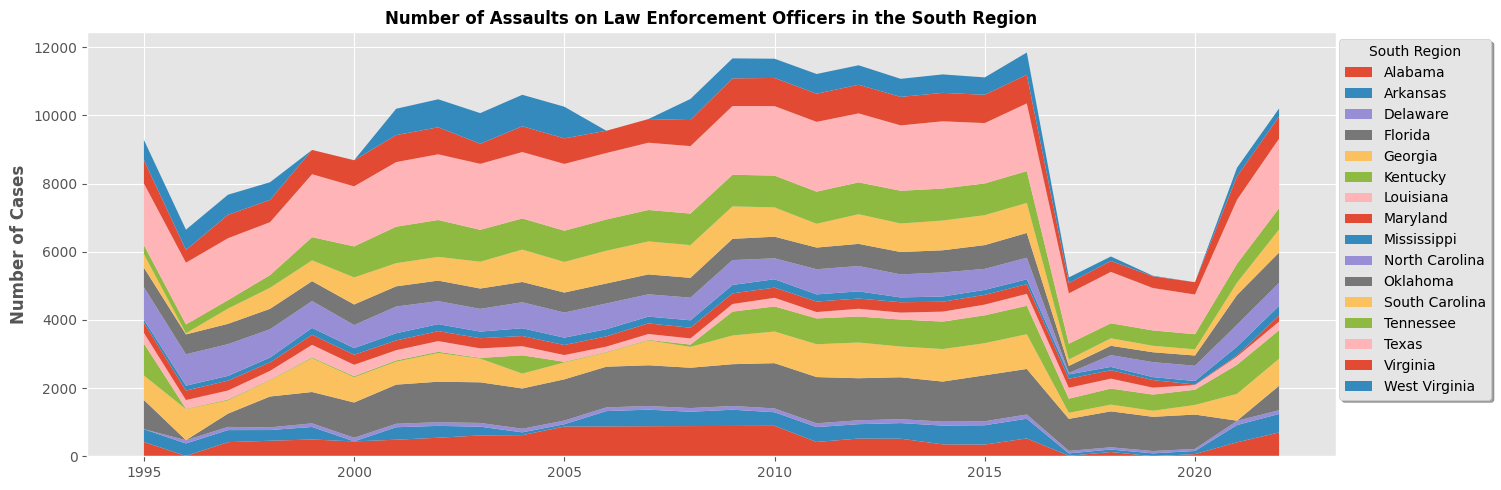

In [39]:
south_region: 'DataFrame' = assult_events.query("REGION_NAME == 'South'").groupby(['DATA_YEAR','STATE']).size().unstack('DATA_YEAR').replace({np.nan:0.0}).transpose()
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot() 
ax.stackplot(south_region.index.tolist(), 
            south_region['Alabama'].tolist(),
            south_region['Arkansas'].tolist(),
            south_region['Delaware'].tolist(),
            south_region['Florida'].tolist(),
            south_region['Georgia'].tolist(),
            south_region['Kentucky'].tolist(),
            south_region['Louisiana'].tolist(),
            south_region['Maryland'].tolist(),
            south_region['Mississippi'].tolist(),
            south_region['North Carolina'].tolist(),
            south_region['Oklahoma'].tolist(),
            south_region['South Carolina'].tolist(),
            south_region['Tennessee'].tolist(),
            south_region['Texas'].tolist(),
            south_region['Virginia'].tolist(),
            south_region['West Virginia'].tolist(), 
            # colors=sns.color_palette(n_colors=20, palette='flare'), 
            labels=south_region.columns.tolist())

ax.set_title("Number of Assaults on Law Enforcement Officers in the South Region", fontweight='bold', fontsize=12)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.legend(title="South Region", fancybox=True, shadow=True, bbox_to_anchor=(1.13,1)) 
plt.tight_layout()

## **Law Enforcement Officers Activities Names in The South Region** 

In [82]:
leoka_df.query("REGION_NAME == 'South'").groupby(['STATE','ACTIVITY_NAME']).size().unstack('STATE')

STATE,Alabama,Arkansas,Delaware,Florida,Georgia,Kentucky,Louisiana,Maryland,Mississippi,North Carolina,Oklahoma,South Carolina,Tennessee,Texas,Virginia,West Virginia
ACTIVITY_NAME,,,,,,,,,,,,,,,,
All Other,6564,4398,1265,13989,9070,4792,3514,3653,2364,8971,7602,8643,9585,24258,8778,6099
Ambush - No Warning,6532,4324,1194,13923,8994,4448,3464,3625,2336,8665,7392,8513,9263,23930,8517,6024
Attempting Other Arrests,6566,4411,1287,13987,9050,4985,3500,3654,2366,9012,7464,8709,9748,24446,8882,6065
Burglaries in Progress or Pursuing Burglary Suspects,6533,4343,1198,13932,8989,4473,3466,3630,2338,8693,7394,8535,9303,23990,8542,6030
Civil Disorder,6530,4330,1217,13937,8992,4442,3466,3623,2339,8667,7393,8531,9274,23961,8544,6023
Handling Persons with Mental Illness,6534,4339,1233,13950,9022,4508,3474,3639,2344,8731,7419,8535,9380,24033,8629,6026
"Handling, Transporting, Custody of Prisoners",6561,4387,1273,13968,9059,4659,3506,3656,2363,8882,7558,8669,9584,24333,8747,6041
Investigating Suspicious Persons or Circumstances,6557,4388,1231,13970,9060,4633,3497,3648,2357,8910,7471,8617,9564,24272,8733,6032
Responding to Disturbance Calls,6595,4454,1285,14008,9091,4968,3519,3653,2381,9111,7476,8775,9893,24545,8933,6099


## **Incidents/Arrest Involving Firearms in the South Region**

In [111]:
states_south: List[str] = leoka_df.query("REGION_NAME == 'South'")['STATE'].unique().tolist()
states_south.remove(None)
states_south.sort()
south_crime_summary: 'DataFrame' = leoka_df.query("REGION_NAME == 'South'").groupby(['DATA_YEAR', 'STATE' ])['FIREARM_ACTUAL'].sum().unstack('STATE').replace({np.nan:0.0})

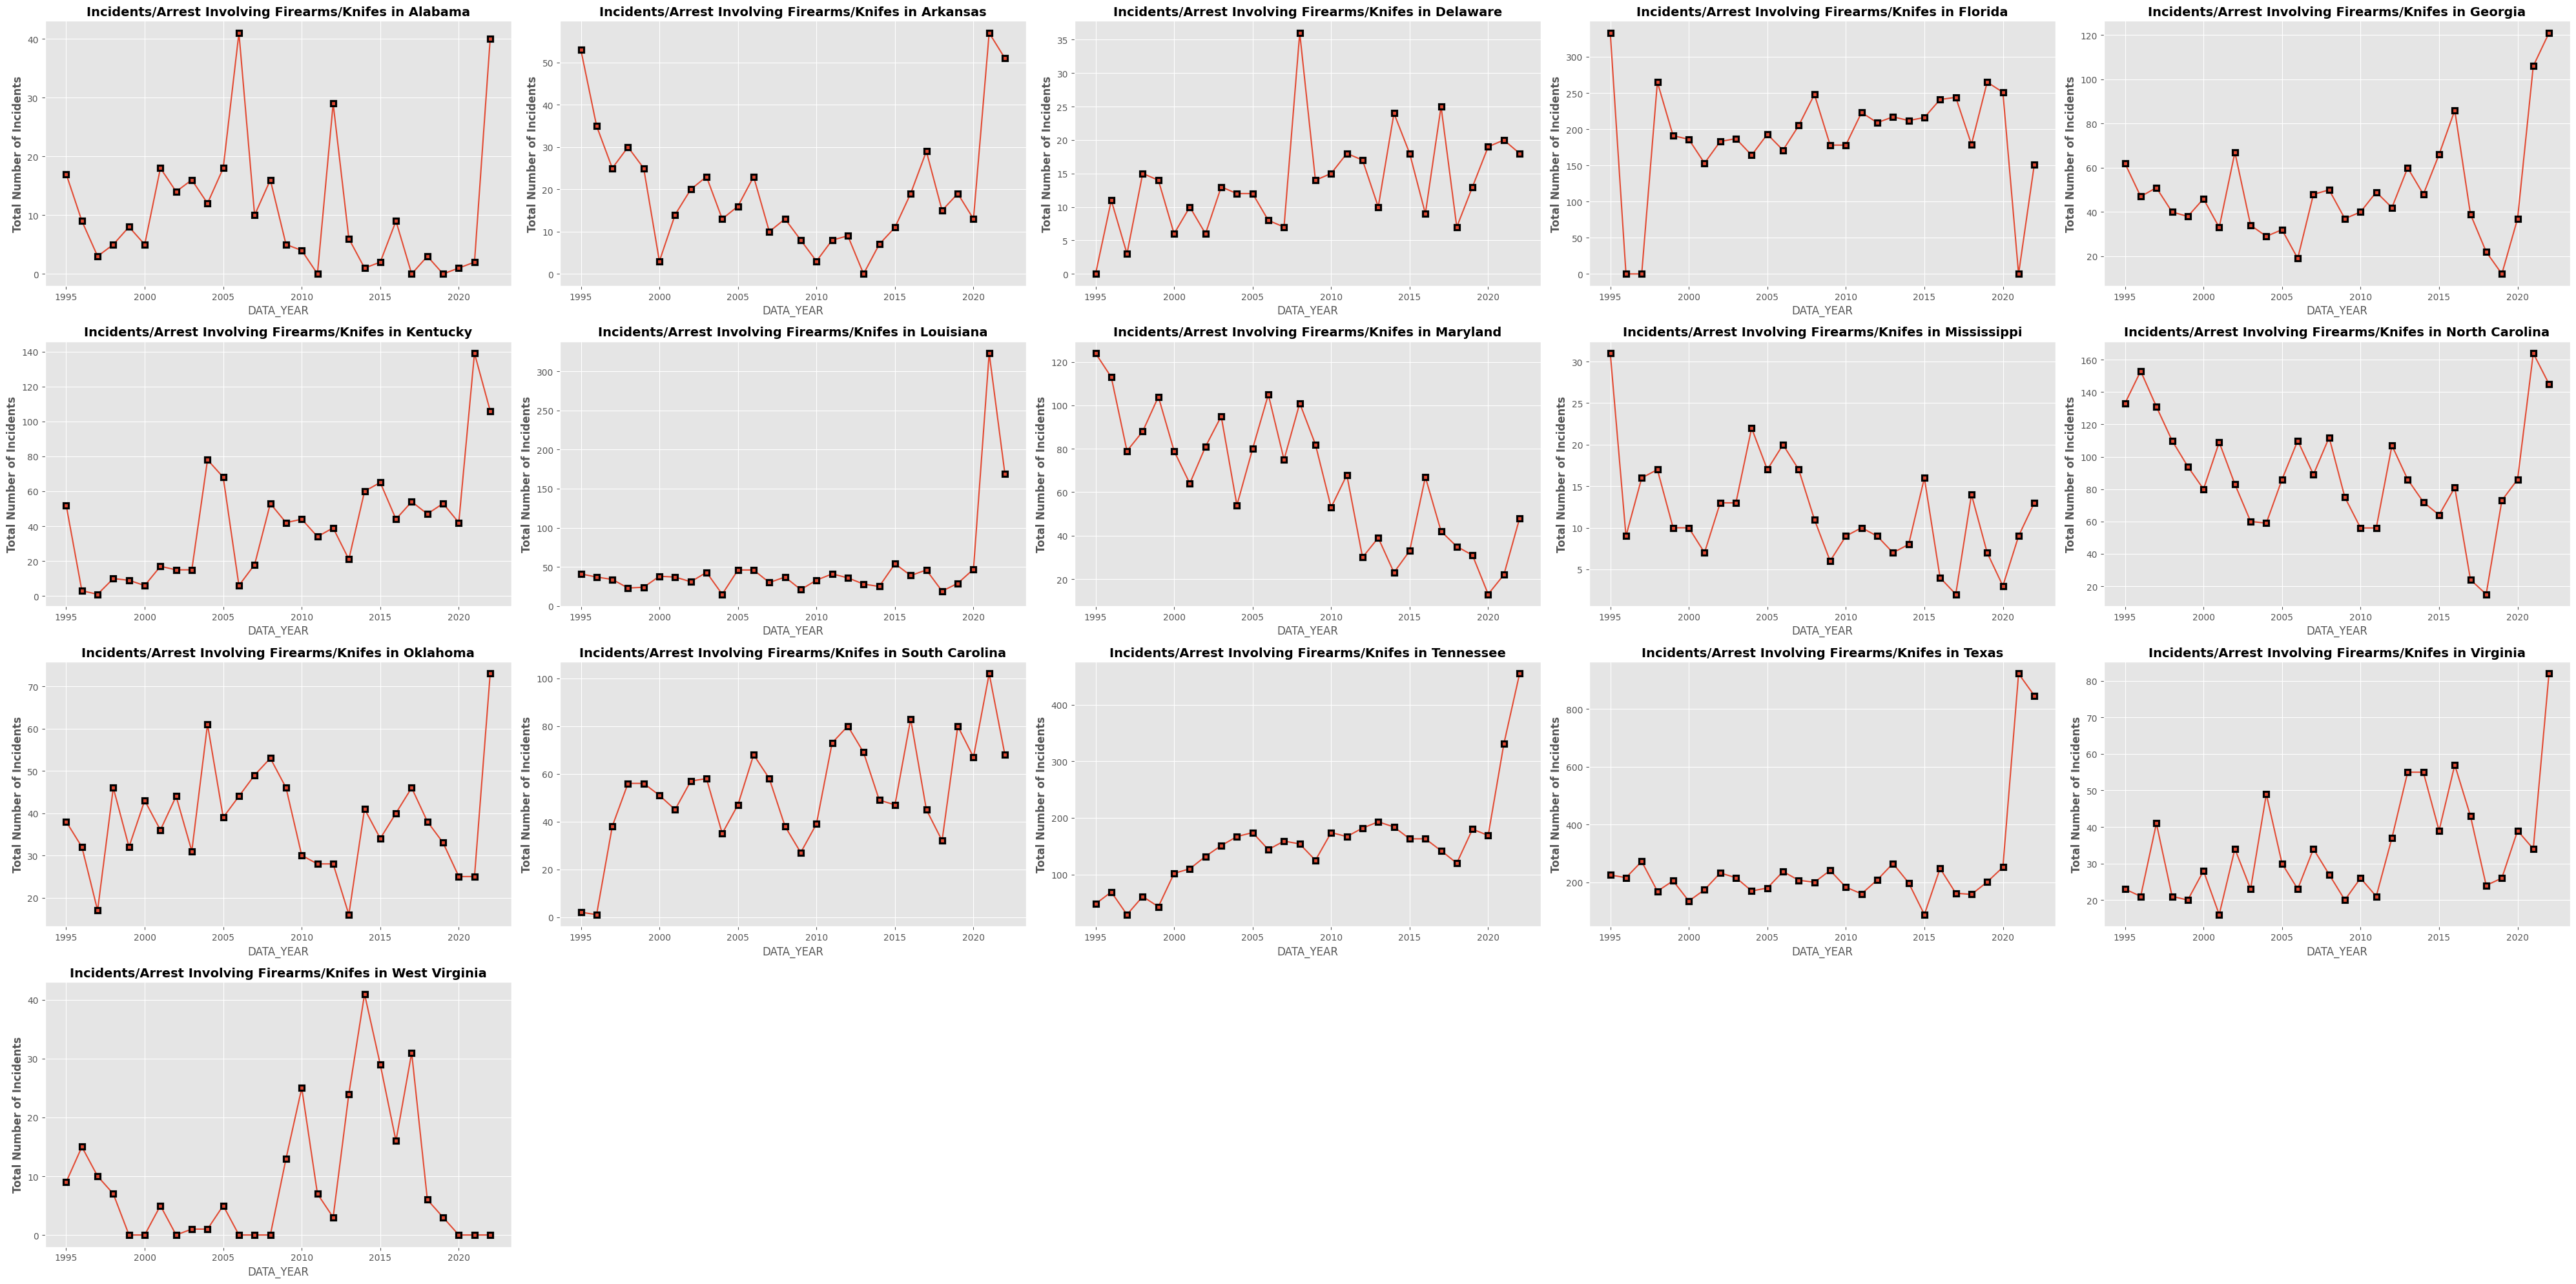

In [139]:
fig = plt.figure(figsize=(40,20))
for index,state in enumerate(states_south,1): 
    ax = fig.add_subplot(4,5,index)
    south_crime_summary[state].plot(ax=ax, marker='s', mec='black', mew=2.3)
    ax.set_title(f"Incidents/Arrest Involving Firearms/Knifes in {state}", fontweight='bold', fontsize=14)
    ax.set_ylabel("Total Number of Incidents", fontweight='bold')
plt.tight_layout() 

In [140]:
# Incidents time 12am - 2am

## **Number of Assaults on Law Enforcement Officers in the West Region**

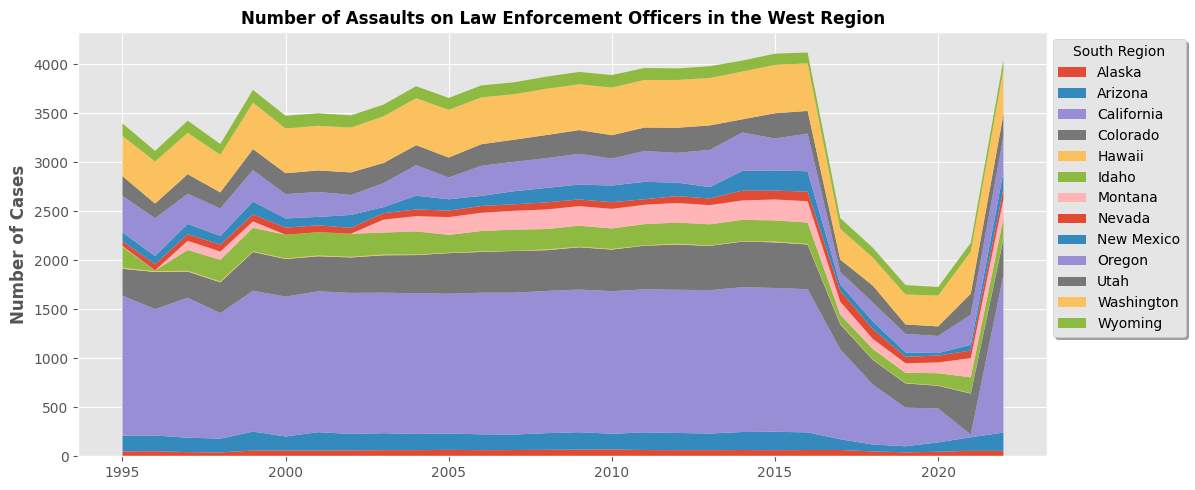

In [38]:
fig = plt.figure(figsize=(12,5)) 
ax = fig.add_subplot() 

west_region: 'DataFrame' = assult_events.query("REGION_NAME == 'West' ").groupby(['DATA_YEAR','STATE']).size().unstack('STATE').replace({np.nan:0.0})
ax.stackplot(west_region.index.tolist(),
             west_region['Alaska'].tolist(),
             west_region['Arizona'].tolist(),
             west_region['California'].tolist(),
             west_region['Colorado'].tolist(),
             west_region['Hawaii'].tolist(),
             west_region['Idaho'].tolist(),
             west_region['Montana'].tolist(),
             west_region['Nevada'].tolist(),
             west_region['New Mexico'].tolist(),
             west_region['Oregon'].tolist(),
             west_region['Utah'].tolist(),
             west_region['Washington'].tolist(),
             west_region['Wyoming'].tolist(), 
            labels=west_region.columns.tolist())# , 
            # colors=sns.color_palette(palette='flare', n_colors=15)) 

ax.set_title("Number of Assaults on Law Enforcement Officers in the West Region", fontweight='bold', fontsize=12)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.legend(title="South Region", fancybox=True, shadow=True, bbox_to_anchor=(1.15,1)) 
plt.tight_layout()